# The one

THIS IS THE CODE

In [2]:


API_key = "sk-proj-LUEpW0YTvNdhWQz9ggJYTXUyEJ4v7vfkdm49YKmvIV8KgaLoxefnkbyEJ" + \
          "3wB0ghKz3KqimQRfhT3BlbkFJO_0ZjunEtojKMejA32OkyN4oltchuhHDpALzB7f0" + \
          "3FIaKuFbRXsz_staA-raUsdogLXOKSfc0A"

In [2]:
# experiment.py main
import os, io, json, csv, time, zipfile, requests, re
from pathlib import Path

import openai
import pandas as pd

# ───────────────────────────────────────────────────────────────────────────────
# 1) Download & load SST-2 train.tsv
# ───────────────────────────────────────────────────────────────────────────────
GLUE_URL = "https://dl.fbaipublicfiles.com/glue/data/SST-2.zip"
df = pd.read_csv(
    zipfile.ZipFile(io.BytesIO(requests.get(GLUE_URL).content))
           .open("SST-2/train.tsv"), sep="\t"
)
k = 200
# 2) Sub-sample 25 pos / 25 neg
df_pos = df[df.label == 1].sample(k, random_state=42)
df_neg = df[df.label == 0].sample(k, random_state=42)
subset  = pd.concat([df_pos, df_neg]).reset_index(drop=True)

examples = [
    dict(id=i, text=row.sentence,
         label=("positive" if row.label == 1 else "negative"))
    for i, row in subset.iterrows()
]

# ───────────────────────────────────────────────────────────────────────────────
# 3) Config
# ───────────────────────────────────────────────────────────────────────────────
SC_SAMPLES = 7
ROOT_DIR   = Path(".")  # ← NEW
RAW_DIR    = ROOT_DIR/"results/raw"
SUMMARY_CSV = ROOT_DIR/"results/summary.csv"
for d in (RAW_DIR, RAW_DIR/"direct", RAW_DIR/"cot", RAW_DIR/"sc_cot"):
    d.mkdir(parents=True, exist_ok=True)

openai.api_key = API_key   # set in your shell
MODEL          = "gpt-4o-mini"
RATE_SLEEP     = 1.0

# ───────────────────────────────────────────────────────────────────────────────
# 4) Helpers
# ───────────────────────────────────────────────────────────────────────────────
SYSTEM_MSG = {
    "role": "system",
    "content": (
        "You are a sentiment-analysis assistant. "
        "After your reasoning, output **exactly one line** of the form:\n"
        "##LABEL## POSITIVE\n"
        "or\n"
        "##LABEL## NEGATIVE\n"
        "Do not put anything else on that line."
    )
}

def call_openai(prompt, temperature=0.0, max_tokens=256):  # ← bumped to 256
    return openai.chat.completions.create(
        model=MODEL,
        messages=[SYSTEM_MSG, {"role": "user", "content": prompt}],
        temperature=temperature,
        max_tokens=max_tokens,
    )

LABEL_RE = re.compile(r"^##LABEL##\s*(positive|negative)\s*$", re.I)

def parse_label(text: str) -> str:
    matches = [m.group(1).lower()
               for line in text.splitlines()
               for m in (LABEL_RE.match(line.strip()),) if m]
    if len(matches) != 1:
        raise ValueError(f"Expected exactly one ##LABEL## line, found {len(matches)}.\n{text}")
    return matches[0]

# ───────────────────────────────────────────────────────────────────────────────
# 5) Prompt templates
# ───────────────────────────────────────────────────────────────────────────────
TAG_RULE = (
    "\n\n---\n"
    "After your reasoning, write ONE final line that starts with "
    "##LABEL## and then the single word POSITIVE or NEGATIVE. "
    "Write nothing else on that line (do not even punctutuate the line with \":\").\n"
    "---"
)

def prompt_direct(ex):
    return f"""{ex['text']}

This review has been classified either positive or negative (exactly one).
You are to decipher which classification is true.
Is this review positive or negative?{TAG_RULE}"""

def prompt_cot(ex):
    return f"""{ex['text']}

Let's think step by step.
What has the reviewer said/not said to suggest that their opinion is positive?
What have they said/not said to suggest that their opinion is negative.
Weigh both sides. Which classification (positive or negative) seems to have more
evidence? Is this review positive or negative?{TAG_RULE}"""

# ───────────────────────────────────────────────────────────────────────────────
# 6) Runners
# ───────────────────────────────────────────────────────────────────────────────
def run_direct(ex): return call_openai(prompt_direct(ex), temperature=0.0)
def run_cot(ex):    return call_openai(prompt_cot(ex),   temperature=0.0)

def run_sc_cot(ex, n=SC_SAMPLES):
    outs, prompt = [], prompt_cot(ex)
    for _ in range(n):
        outs.append(call_openai(prompt, temperature=0.7))
        time.sleep(RATE_SLEEP)
    return outs

# ───────────────────────────────────────────────────────────────────────────────
# 7) Main experiment loop
# ───────────────────────────────────────────────────────────────────────────────
def main():
    with open(SUMMARY_CSV, "w", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(f, fieldnames=[
            "snippet_id", "strategy", "true_label", "pred_label", "vote_margin"])
        writer.writeheader()
        i = 0
        for ex in examples:
            i += 1

            sid, gold = ex["id"], ex["label"]

            # ------- Direct -------
            try:
                resp = run_direct(ex)
                (RAW_DIR/"direct"/f"{sid}.json").write_text(
                    json.dumps(resp.model_dump(), indent=2))
                pred = parse_label(resp.choices[0].message.content)
                writer.writerow(dict(snippet_id=sid, strategy="direct",
                                     true_label=gold, pred_label=pred,
                                     vote_margin=""))
            except Exception as e:
                print("[Direct]", sid, e)
            time.sleep(RATE_SLEEP)

            # ------- CoT ----------
            try:
                resp = run_cot(ex)
                (RAW_DIR/"cot"/f"{sid}.json").write_text(
                    json.dumps(resp.model_dump(), indent=2))
                pred = parse_label(resp.choices[0].message.content)
                writer.writerow(dict(snippet_id=sid, strategy="cot",
                                     true_label=gold, pred_label=pred,
                                     vote_margin=""))
            except Exception as e:
                print("[CoT]", sid, e)
            time.sleep(RATE_SLEEP)

            # ------- SC-CoT -------
            try:
                samples = run_sc_cot(ex)
                texts   = [s.choices[0].message.content for s in samples]
                (RAW_DIR/"sc_cot"/f"{sid}.json").write_text(
                    json.dumps(texts, indent=2))
                labels  = [parse_label(t) for t in texts]
                counts  = {lbl: labels.count(lbl) for lbl in ("positive","negative")}
                pred    = max(counts, key=counts.get)
                other   = "negative" if pred == "positive" else "positive"
                margin  = (counts[pred] - counts[other]) / SC_SAMPLES
                writer.writerow(dict(snippet_id=sid, strategy="sc_cot",
                                     true_label=gold, pred_label=pred,
                                     vote_margin=margin))
            except Exception as e:
                print("[SC-CoT]", sid, e)
            time.sleep(RATE_SLEEP)
            if i % 50 == 0:
                print(f'{i/5}%')

    print("✓ Experiment complete →", SUMMARY_CSV)

if __name__ == "__main__":
    main()


NameError: name 'API_key' is not defined

In [ ]:
# experiment.py Speed Optimized
import os, io, json, csv, time, zipfile, requests, re
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor, as_completed
import threading

import openai
import pandas as pd

# ───────────────────────────────────────────────────────────────────────────────
# 1) Download & load SST-2 train.tsv
# ───────────────────────────────────────────────────────────────────────────────

GLUE_URL = "https://dl.fbaipublicfiles.com/glue/data/SST-2.zip"
df = pd.read_csv(
    zipfile.ZipFile(io.BytesIO(requests.get(GLUE_URL).content))
           .open("SST-2/train.tsv"), sep="\t"
)
k = 200
# 2) Sub-sample k pos / k neg
df_pos = df[df.label == 1].sample(k, random_state=42)
df_neg = df[df.label == 0].sample(k, random_state=42)
subset  = pd.concat([df_pos, df_neg]).reset_index(drop=True)

examples = [
    dict(id=i, text=row.sentence,
         label=("positive" if row.label == 1 else "negative"))
    for i, row in subset.iterrows()
]

# ───────────────────────────────────────────────────────────────────────────────
# 3) Config
# ───────────────────────────────────────────────────────────────────────────────
SC_SAMPLES = 7
ROOT_DIR   = Path(".")  # ← Changed to current directory
RAW_DIR    = ROOT_DIR/"results/raw"
SUMMARY_CSV = ROOT_DIR/"results/summary.csv"
for d in (RAW_DIR, RAW_DIR/"direct", RAW_DIR/"cot", RAW_DIR/"sc_cot"):
    d.mkdir(parents=True, exist_ok=True)

openai.api_key = API_key   # set in your shell
MODEL          = "gpt-4o-mini"
print(MODEL)
RATE_SLEEP     = 1.0  # Not used in parallel version, but keeping for compatibility

# ───────────────────────────────────────────────────────────────────────────────
# 4) Helpers
# ───────────────────────────────────────────────────────────────────────────────
SYSTEM_MSG = {
    "role": "system",
    "content": (
        "You are a sentiment-analysis assistant. "
        "After your reasoning, output **exactly one line** of the form:\n"
        "##LABEL## POSITIVE\n"
        "or\n"
        "##LABEL## NEGATIVE\n"
        "Do not put anything else on that line."
    )
}

def call_openai(prompt, temperature=0.0, max_tokens=256):  #  bumped to 256
    return openai.chat.completions.create(
        model=MODEL,
        messages=[SYSTEM_MSG, {"role": "user", "content": prompt}],
        temperature=temperature,
        max_tokens=max_tokens,
    )

LABEL_RE = re.compile(r"^##LABEL##\s*(positive|negative)\s*$", re.I)

def parse_label(text: str) -> str:
    matches = [m.group(1).lower()
               for line in text.splitlines()
               for m in (LABEL_RE.match(line.strip()),) if m]
    if len(matches) != 1:
        raise ValueError(f"Expected exactly one ##LABEL## line, found {len(matches)}.\n{text}")
    return matches[0]

# ───────────────────────────────────────────────────────────────────────────────
# 5) Prompt templates
# ───────────────────────────────────────────────────────────────────────────────
TAG_RULE = (
    "\n\n---\n"
    "After your reasoning, write ONE final line that starts with "
    "##LABEL## and then the single word POSITIVE or NEGATIVE. "
    "Write nothing else on that line (do not even punctutuate the line with \":\").\n"
    "---"
)

def prompt_direct(ex):
    return f"""{ex['text']}

This review has been classified either positive or negative (exactly one).
You are to decipher which classification is true.
Is this review positive or negative?{TAG_RULE}"""

def prompt_cot(ex):
    return f"""{ex['text']}

Let's think step by step.
What has the reviewer said/not said to suggest that their opinion is positive?
What have they said/not said to suggest that their opinion is negative.
Weigh both sides. Which classification (positive or negative) seems to have more
evidence? Is this review positive or negative?{TAG_RULE}"""

# ───────────────────────────────────────────────────────────────────────────────
# 6) Runners
# ───────────────────────────────────────────────────────────────────────────────
def run_direct(ex): return call_openai(prompt_direct(ex), temperature=0.0)
def run_cot(ex):    return call_openai(prompt_cot(ex),   temperature=0.0)

def run_sc_cot(ex, n=SC_SAMPLES):
    outs, prompt = [], prompt_cot(ex)
    # Parallelize the SC-CoT samples
    with ThreadPoolExecutor(max_workers=5) as executor:
        futures = [executor.submit(call_openai, prompt, 0.0) for _ in range(n)]
        outs = [future.result() for future in as_completed(futures)]
    return outs

# ───────────────────────────────────────────────────────────────────────────────
# 7) Helper to process each example
# ───────────────────────────────────────────────────────────────────────────────
def process_example(ex):
    """Process a single example with all three strategies"""
    sid, gold = ex["id"], ex["label"]
    results = []
    
    # ------- Direct -------
    try:
        resp = run_direct(ex)
        (RAW_DIR/"direct"/f"{sid}.json").write_text(
            json.dumps(resp.model_dump(), indent=2))
        pred = parse_label(resp.choices[0].message.content)
        results.append(dict(snippet_id=sid, strategy="direct",
                           true_label=gold, pred_label=pred,
                           vote_margin=""))
    except Exception as e:
        print("[Direct]", sid, e)

    # ------- CoT ----------
    try:
        resp = run_cot(ex)
        (RAW_DIR/"cot"/f"{sid}.json").write_text(
            json.dumps(resp.model_dump(), indent=2))
        pred = parse_label(resp.choices[0].message.content)
        results.append(dict(snippet_id=sid, strategy="cot",
                           true_label=gold, pred_label=pred,
                           vote_margin=""))
    except Exception as e:
        print("[CoT]", sid, e)

    # ------- SC-CoT -------
    try:
        samples = run_sc_cot(ex)
        texts   = [s.choices[0].message.content for s in samples]
        (RAW_DIR/"sc_cot"/f"{sid}.json").write_text(
            json.dumps(texts, indent=2))
        labels  = [parse_label(t) for t in texts]
        counts  = {lbl: labels.count(lbl) for lbl in ("positive","negative")}
        pred    = max(counts, key=counts.get)
        other   = "negative" if pred == "positive" else "positive"
        margin  = (counts[pred] - counts[other]) / SC_SAMPLES
        results.append(dict(snippet_id=sid, strategy="sc_cot",
                           true_label=gold, pred_label=pred,
                           vote_margin=margin))
    except Exception as e:
        print("[SC-CoT]", sid, e)
    
    return results

# ───────────────────────────────────────────────────────────────────────────────
# 8) Main experiment loop
# ───────────────────────────────────────────────────────────────────────────────
def main():
    MAX_WORKERS = 10  # Adjust based on rate limits
    all_results = []
    completed_count = 0
    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        future_to_ex = {executor.submit(process_example, ex): ex for ex in examples}
        for future in as_completed(future_to_ex):
            try:
                results = future.result()
                all_results.extend(results)
                completed_count += 1
#progress
                if completed_count % 50 == 0:
                    progress = (completed_count / len(examples)) * 100
                    print(f'{progress:.1f}% complete ({completed_count}/{len(examples)} examples)')
            except Exception as e:
                ex = future_to_ex[future]
                print(f"Error:{ex['id']}: {e}")
    with open(SUMMARY_CSV, "w", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(f, fieldnames=[
            "snippet_id", "strategy", "true_label", "pred_label", "vote_margin"])
        writer.writeheader()
        all_results.sort(key=lambda x: (x["snippet_id"], x["strategy"]))
        writer.writerows(all_results)
    print("✓ Experiment complete →", SUMMARY_CSV)
if __name__ == "__main__":
    main()


gpt-4o-mini
[Direct] 41 Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-x7N9OBzXo6Pfp40FfKaHDJZ3 on requests per day (RPD): Limit 10000, Used 10000, Requested 1. Please try again in 8.64s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}}
[Direct] 32 Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-x7N9OBzXo6Pfp40FfKaHDJZ3 on requests per day (RPD): Limit 10000, Used 10000, Requested 1. Please try again in 8.64s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}}
[Direct] 42 Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-x7N9OBzXo6Pfp40FfKaHDJZ3 on requests per day (RPD): Limit 10000, Used 10000, Requested 1. Please try again in 8.64s. Visit https://platform.openai.com/acc

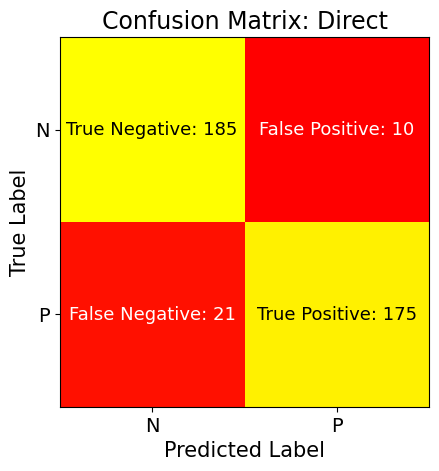

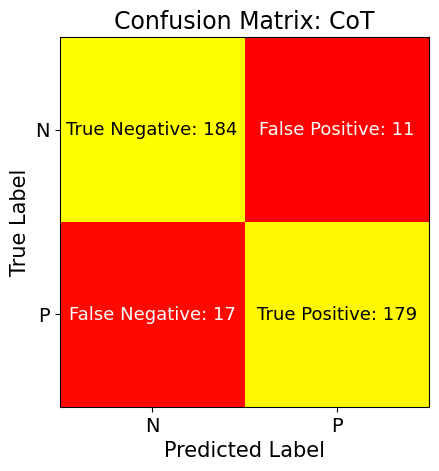

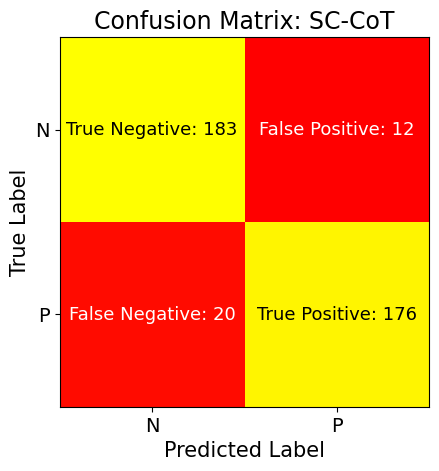

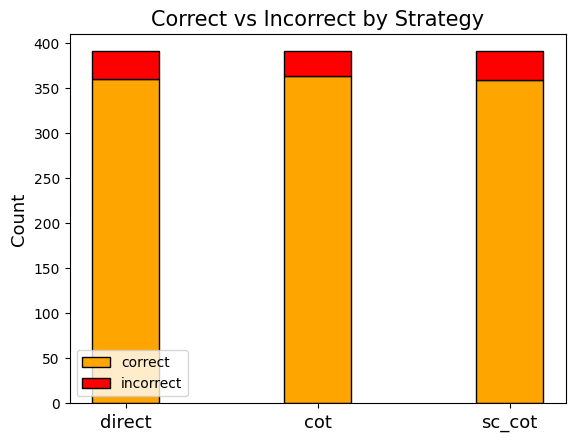

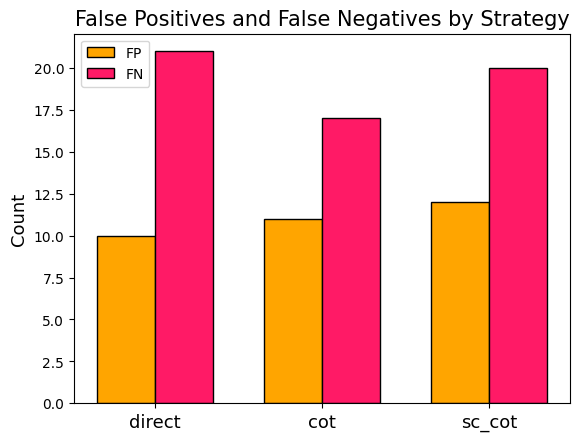

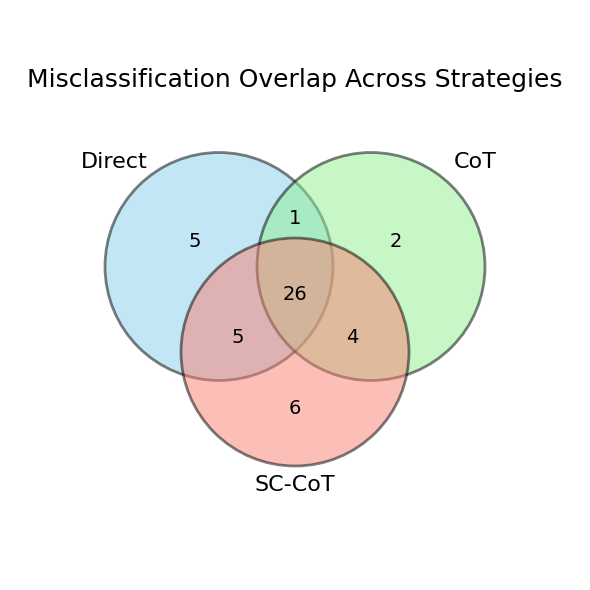

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
from statsmodels.stats.contingency_tables import mcnemar
filepath = "C:/Users/Noor/Desktop/159_new/results/summary.csv"
# Load data
df = pd.read_csv(filepath)

# Count how many strategies each snippet has
strategy_counts = df.groupby('snippet_id')['strategy'].nunique()

# Keep only snippet_ids present in all 3 strategies
valid_ids = strategy_counts[strategy_counts == 3].index

# Filter the DataFrame to those valid snippet_ids
df = df[df['snippet_id'].isin(valid_ids)].reset_index(drop=True)

# Now df contains only snippet_ids with classifications for direct, cot, and sc_cot.


# 1. Confusion matrices per strategy
strategies = ['direct', 'cot', 'sc_cot']
label = ["Direct", "CoT", "SC-CoT"]
figures = {}
for i, strat in enumerate(strategies):
    sub = df[df['strategy'] == strat]
    cm = confusion_matrix(sub['true_label'], sub['pred_label'])

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap="autumn")
    plt.title(f'Confusion Matrix: {label[i]}', fontsize=17)
    plt.xticks([0, 1], ['N', 'P'], fontsize=14)
    plt.yticks([0, 1], ['N', 'P'], fontsize=14)
    plt.xlabel('Predicted Label', fontsize=15)
    plt.ylabel('True Label', fontsize=15)

    # Annotate matrix cells
    for (i, j), val in np.ndenumerate(cm):
        match i, j:
            case 0, 0:
                txt = f'True Negative: {val}'
                plt.text(j, i, txt, ha='center', va='center', color='black', fontsize=13)
            case 1, 1:
                txt = f'True Positive: {val}'
                plt.text(j, i, txt, ha='center', va='center', color='black', fontsize=13)
            case 1, 0:
                txt = f'False Negative: {val}'
                plt.text(j, i, txt, ha='center', va='center', color='white', fontsize=13)
            case 0, 1:
                txt = f'False Positive: {val}'
                plt.text(j, i, txt, ha='center', va='center', color='white', fontsize=13)

    plt.show()

# 2. Stacked Bar chart of accuracies
width = 0.35
counts = {}
for strat in strategies:
    sub = df[df.strategy == strat]
    correct = (sub.true_label == sub.pred_label).sum()
    total = len(sub)
    incorrect = total - correct
    counts[strat] = {'correct': correct, 'incorrect': incorrect}

fig, ax = plt.subplots()
x = np.arange(len(strategies))
corrects = [counts[s]['correct'] for s in strategies]
incorrects = [counts[s]['incorrect'] for s in strategies]
ax.bar(x, corrects, width, label='correct', color='orange', edgecolor="k")
ax.bar(x, incorrects, width, bottom=corrects, label='incorrect', color='red', edgecolor="k")
ax.set_xticks(x)
ax.set_xticklabels(strategies, fontsize=13)
ax.set_ylabel('Count', fontsize=13)
ax.set_title('Correct vs Incorrect by Strategy', fontsize=15)
ax.legend()
plt.show()

# 3. Grouped bar: False Positives vs False Negatives
fp = []
fn = []
for strat in strategies:
    sub = df[df.strategy == strat]
    cm = confusion_matrix(sub.true_label, sub.pred_label)
    tn, fp_count, fn_count, tp = cm.ravel()
    fp.append(fp_count)
    fn.append(fn_count)

fig, ax = plt.subplots()
x = np.arange(len(strategies))
ax.bar(x - width/2, fp, width, label='FP', color='orange', edgecolor="k")
ax.bar(x + width/2, fn, width, label='FN', color=(1,0.1,0.4), edgecolor="k")
ax.set_xticks(x)
ax.set_xticklabels(strategies, fontsize=13)
ax.set_ylabel('Count', fontsize=13)
ax.set_title('False Positives and False Negatives by Strategy', fontsize=15)
ax.legend()
plt.show()

from matplotlib_venn import venn3, venn3_circles
from matplotlib.patches import Circle

# Pivot to wide format
fig, ax = plt.subplots(figsize=(6,6))

# Circle parameters
coords = {'Direct': (-1.90, 1.40), 'CoT': (1.90, 1.40), 'SC-CoT': (0, -2.0)}
centers = {'Direct': (-0.8, 0.3), 'CoT': (0.8, 0.3), 'SC-CoT': (0, -0.6)}
radius = 1.2

# Draw circles
colors = {'Direct': 'skyblue', 'CoT': 'lightgreen', 'SC-CoT': 'salmon'}
for name, center in centers.items():
    circ = Circle(center, radius=radius, alpha=0.5, linewidth=2,
                  edgecolor='black', facecolor=colors[name])
    ax.add_patch(circ)


# Subset counts
counts = {
    '100': 5,   # Direct only
    '010': 2,   # CoT only
    '001': 6,   # SC-CoT only
    '110': 1,   # Direct & CoT
    '101': 5,   # Direct & SC-CoT
    '011': 4,   # CoT & SC-CoT
    '111': 26   # All three
}
# Coordinates for labels
label_coords = {
    '100': (-1.06, 0.56),
    '010': (1.06, 0.56),
    '001': (0, -1.2),
    '110': (0, 0.8),
    '101': (-0.6, -0.45),
    '011': (0.6, -0.45),
    '111': (0, 0)
}


# Place counts
for key, count in counts.items():
    x, y = label_coords[key]
    ax.text(x, y, str(count), ha='center', va='center', fontsize=14)

# Place set labels
for name in coords.keys():
    ax.text(coords[name][0], coords[name][1], name, ha='center', va='center', fontsize=16)

ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.axis('off')
ax.set_title(
    'Misclassification Overlap Across Strategies',
    fontsize=18,
    y=0.85        # default is y=1.00; lower means “bring it down”
)
plt.tight_layout()
plt.show()


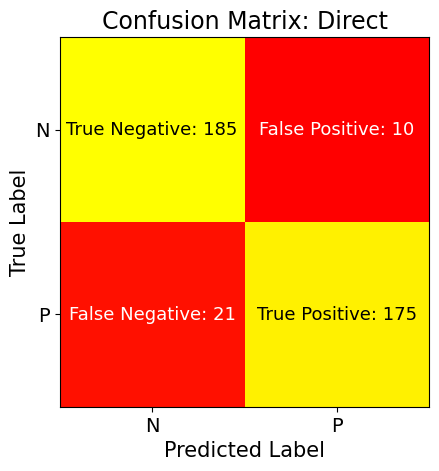

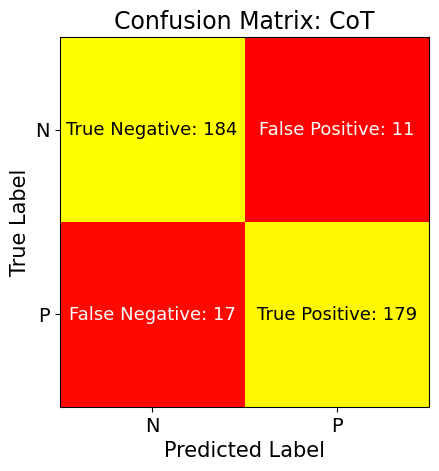

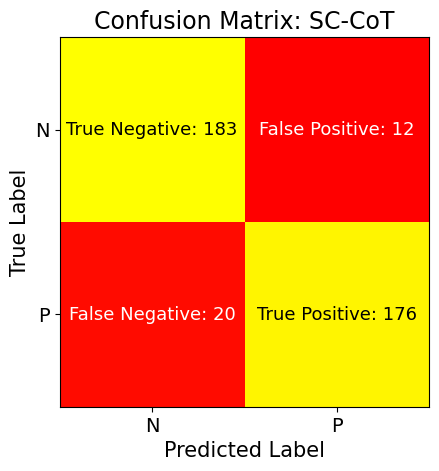

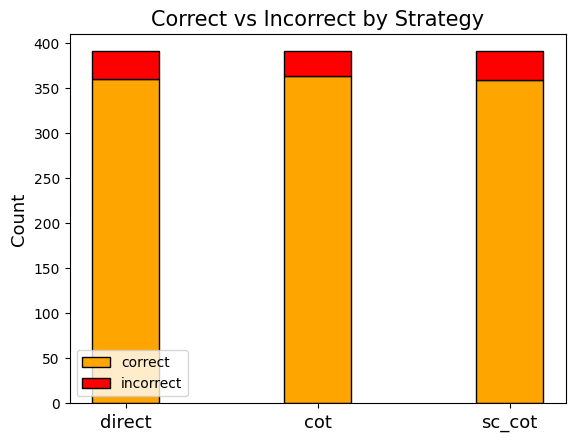

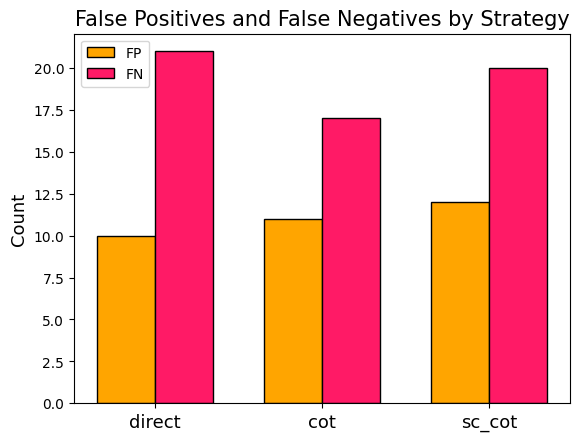

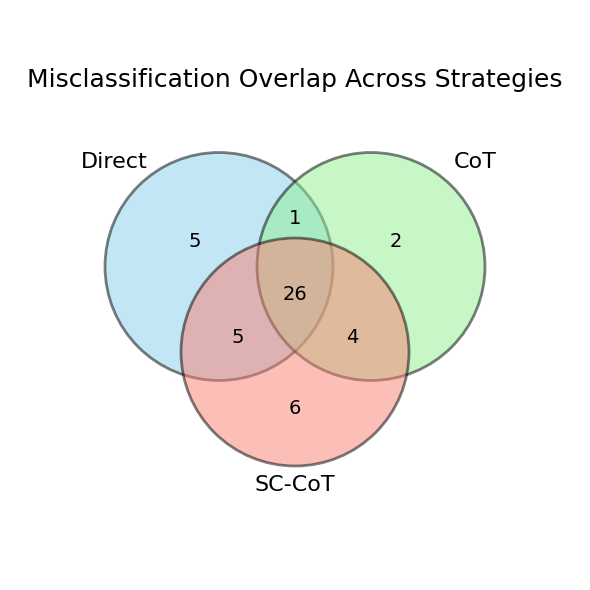

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
from statsmodels.stats.contingency_tables import mcnemar
filepath = "C:/Users/Noor/Desktop/159_new/results/summary.csv"
# Load data
df = pd.read_csv(filepath)

# Count how many strategies each snippet has
strategy_counts = df.groupby('snippet_id')['strategy'].nunique()

# Keep only snippet_ids present in all 3 strategies
valid_ids = strategy_counts[strategy_counts == 3].index

# Filter the DataFrame to those valid snippet_ids
df = df[df['snippet_id'].isin(valid_ids)].reset_index(drop=True)

# Now df contains only snippet_ids with classifications for direct, cot, and sc_cot.


# 1. Confusion matrices per strategy
strategies = ['direct', 'cot', 'sc_cot']
label = ["Direct", "CoT", "SC-CoT"]
figures = {}
for i, strat in enumerate(strategies):
    sub = df[df['strategy'] == strat]
    cm = confusion_matrix(sub['true_label'], sub['pred_label'])

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap="autumn")
    plt.title(f'Confusion Matrix: {label[i]}', fontsize=17)
    plt.xticks([0, 1], ['N', 'P'], fontsize=14)
    plt.yticks([0, 1], ['N', 'P'], fontsize=14)
    plt.xlabel('Predicted Label', fontsize=15)
    plt.ylabel('True Label', fontsize=15)

    # Annotate matrix cells
    for (i, j), val in np.ndenumerate(cm):
        match i, j:
            case 0, 0:
                txt = f'True Negative: {val}'
                plt.text(j, i, txt, ha='center', va='center', color='black', fontsize=13)
            case 1, 1:
                txt = f'True Positive: {val}'
                plt.text(j, i, txt, ha='center', va='center', color='black', fontsize=13)
            case 1, 0:
                txt = f'False Negative: {val}'
                plt.text(j, i, txt, ha='center', va='center', color='white', fontsize=13)
            case 0, 1:
                txt = f'False Positive: {val}'
                plt.text(j, i, txt, ha='center', va='center', color='white', fontsize=13)

    plt.show()

# 2. Stacked Bar chart of accuracies
width = 0.35
counts = {}
for strat in strategies:
    sub = df[df.strategy == strat]
    correct = (sub.true_label == sub.pred_label).sum()
    total = len(sub)
    incorrect = total - correct
    counts[strat] = {'correct': correct, 'incorrect': incorrect}

fig, ax = plt.subplots()
x = np.arange(len(strategies))
corrects = [counts[s]['correct'] for s in strategies]
incorrects = [counts[s]['incorrect'] for s in strategies]
ax.bar(x, corrects, width, label='correct', color='orange', edgecolor="k")
ax.bar(x, incorrects, width, bottom=corrects, label='incorrect', color='red', edgecolor="k")
ax.set_xticks(x)
ax.set_xticklabels(strategies, fontsize=13)
ax.set_ylabel('Count', fontsize=13)
ax.set_title('Correct vs Incorrect by Strategy', fontsize=15)
ax.legend()
plt.show()

# 3. Grouped bar: False Positives vs False Negatives
fp = []
fn = []
for strat in strategies:
    sub = df[df.strategy == strat]
    cm = confusion_matrix(sub.true_label, sub.pred_label)
    tn, fp_count, fn_count, tp = cm.ravel()
    fp.append(fp_count)
    fn.append(fn_count)

fig, ax = plt.subplots()
x = np.arange(len(strategies))
ax.bar(x - width/2, fp, width, label='FP', color='orange', edgecolor="k")
ax.bar(x + width/2, fn, width, label='FN', color=(1,0.1,0.4), edgecolor="k")
ax.set_xticks(x)
ax.set_xticklabels(strategies, fontsize=13)
ax.set_ylabel('Count', fontsize=13)
ax.set_title('False Positives and False Negatives by Strategy', fontsize=15)
ax.legend()
plt.show()

from matplotlib_venn import venn3, venn3_circles
from matplotlib.patches import Circle

# Pivot to wide format
fig, ax = plt.subplots(figsize=(6,6))

# Circle parameters
coords = {'Direct': (-1.90, 1.40), 'CoT': (1.90, 1.40), 'SC-CoT': (0, -2.0)}
centers = {'Direct': (-0.8, 0.3), 'CoT': (0.8, 0.3), 'SC-CoT': (0, -0.6)}
radius = 1.2

# Draw circles
colors = {'Direct': 'skyblue', 'CoT': 'lightgreen', 'SC-CoT': 'salmon'}
for name, center in centers.items():
    circ = Circle(center, radius=radius, alpha=0.5, linewidth=2,
                  edgecolor='black', facecolor=colors[name])
    ax.add_patch(circ)


# Subset counts
counts = {
    '100': 5,   # Direct only
    '010': 2,   # CoT only
    '001': 6,   # SC-CoT only
    '110': 1,   # Direct & CoT
    '101': 5,   # Direct & SC-CoT
    '011': 4,   # CoT & SC-CoT
    '111': 26   # All three
}
# Coordinates for labels
label_coords = {
    '100': (-1.06, 0.56),
    '010': (1.06, 0.56),
    '001': (0, -1.2),
    '110': (0, 0.8),
    '101': (-0.6, -0.45),
    '011': (0.6, -0.45),
    '111': (0, 0)
}


# Place counts
for key, count in counts.items():
    x, y = label_coords[key]
    ax.text(x, y, str(count), ha='center', va='center', fontsize=14)

# Place set labels
for name in coords.keys():
    ax.text(coords[name][0], coords[name][1], name, ha='center', va='center', fontsize=16)

ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.axis('off')
ax.set_title(
    'Misclassification Overlap Across Strategies',
    fontsize=18,
    y=0.85        # default is y=1.00; lower means “bring it down”
)
plt.tight_layout()
plt.show()


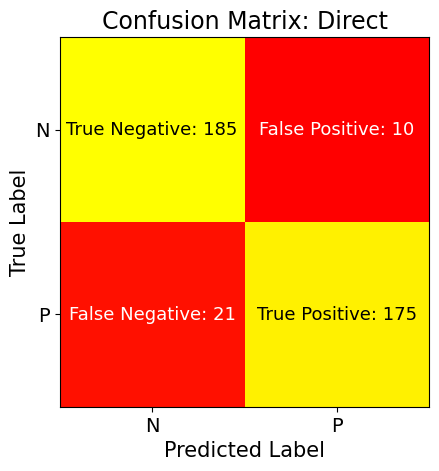

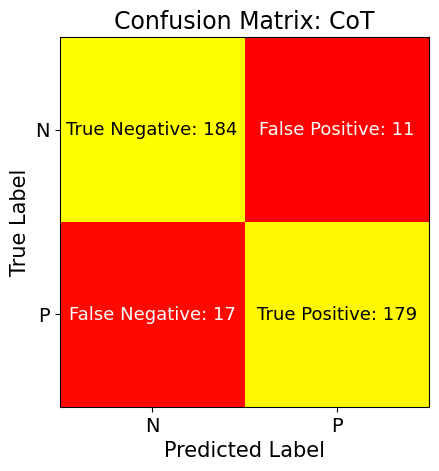

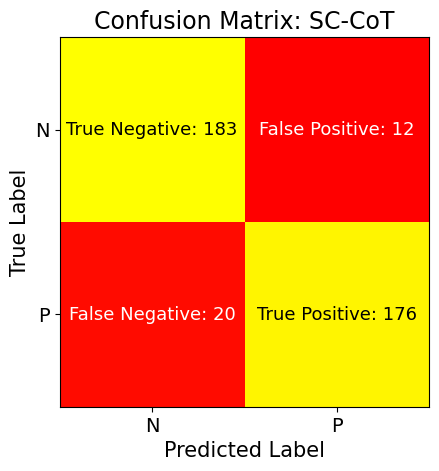

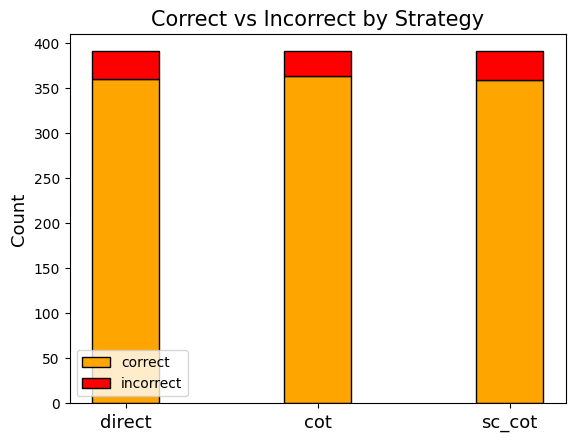

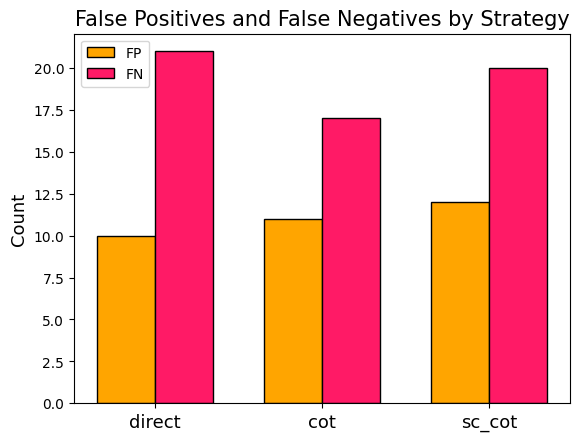

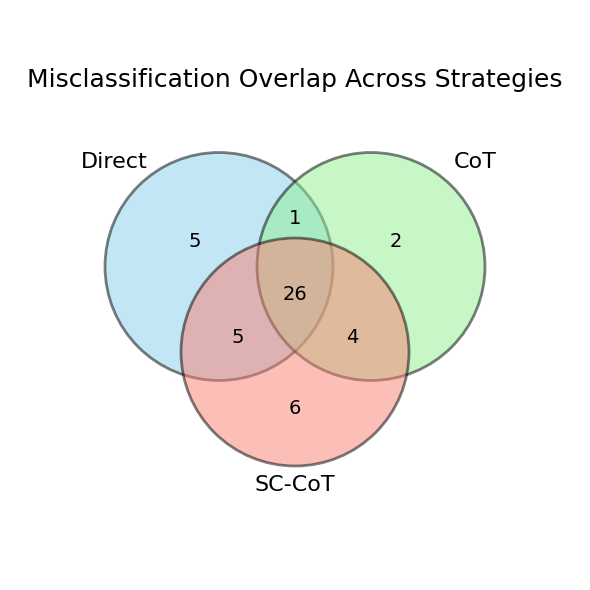

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
from statsmodels.stats.contingency_tables import mcnemar
filepath = "C:/Users/Noor/Desktop/159_new/results/summary.csv"
# Load data
df = pd.read_csv(filepath)

# Count how many strategies each snippet has
strategy_counts = df.groupby('snippet_id')['strategy'].nunique()

# Keep only snippet_ids present in all 3 strategies
valid_ids = strategy_counts[strategy_counts == 3].index

# Filter the DataFrame to those valid snippet_ids
df = df[df['snippet_id'].isin(valid_ids)].reset_index(drop=True)

# Now df contains only snippet_ids with classifications for direct, cot, and sc_cot.


# 1. Confusion matrices per strategy
strategies = ['direct', 'cot', 'sc_cot']
label = ["Direct", "CoT", "SC-CoT"]
figures = {}
for i, strat in enumerate(strategies):
    sub = df[df['strategy'] == strat]
    cm = confusion_matrix(sub['true_label'], sub['pred_label'])

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap="autumn")
    plt.title(f'Confusion Matrix: {label[i]}', fontsize=17)
    plt.xticks([0, 1], ['N', 'P'], fontsize=14)
    plt.yticks([0, 1], ['N', 'P'], fontsize=14)
    plt.xlabel('Predicted Label', fontsize=15)
    plt.ylabel('True Label', fontsize=15)

    # Annotate matrix cells
    for (i, j), val in np.ndenumerate(cm):
        match i, j:
            case 0, 0:
                txt = f'True Negative: {val}'
                plt.text(j, i, txt, ha='center', va='center', color='black', fontsize=13)
            case 1, 1:
                txt = f'True Positive: {val}'
                plt.text(j, i, txt, ha='center', va='center', color='black', fontsize=13)
            case 1, 0:
                txt = f'False Negative: {val}'
                plt.text(j, i, txt, ha='center', va='center', color='white', fontsize=13)
            case 0, 1:
                txt = f'False Positive: {val}'
                plt.text(j, i, txt, ha='center', va='center', color='white', fontsize=13)

    plt.show()

# 2. Stacked Bar chart of accuracies
width = 0.35
counts = {}
for strat in strategies:
    sub = df[df.strategy == strat]
    correct = (sub.true_label == sub.pred_label).sum()
    total = len(sub)
    incorrect = total - correct
    counts[strat] = {'correct': correct, 'incorrect': incorrect}

fig, ax = plt.subplots()
x = np.arange(len(strategies))
corrects = [counts[s]['correct'] for s in strategies]
incorrects = [counts[s]['incorrect'] for s in strategies]
ax.bar(x, corrects, width, label='correct', color='orange', edgecolor="k")
ax.bar(x, incorrects, width, bottom=corrects, label='incorrect', color='red', edgecolor="k")
ax.set_xticks(x)
ax.set_xticklabels(strategies, fontsize=13)
ax.set_ylabel('Count', fontsize=13)
ax.set_title('Correct vs Incorrect by Strategy', fontsize=15)
ax.legend()
plt.show()

# 3. Grouped bar: False Positives vs False Negatives
fp = []
fn = []
for strat in strategies:
    sub = df[df.strategy == strat]
    cm = confusion_matrix(sub.true_label, sub.pred_label)
    tn, fp_count, fn_count, tp = cm.ravel()
    fp.append(fp_count)
    fn.append(fn_count)

fig, ax = plt.subplots()
x = np.arange(len(strategies))
ax.bar(x - width/2, fp, width, label='FP', color='orange', edgecolor="k")
ax.bar(x + width/2, fn, width, label='FN', color=(1,0.1,0.4), edgecolor="k")
ax.set_xticks(x)
ax.set_xticklabels(strategies, fontsize=13)
ax.set_ylabel('Count', fontsize=13)
ax.set_title('False Positives and False Negatives by Strategy', fontsize=15)
ax.legend()
plt.show()

from matplotlib_venn import venn3, venn3_circles
from matplotlib.patches import Circle

# Pivot to wide format
fig, ax = plt.subplots(figsize=(6,6))

# Circle parameters
coords = {'Direct': (-1.90, 1.40), 'CoT': (1.90, 1.40), 'SC-CoT': (0, -2.0)}
centers = {'Direct': (-0.8, 0.3), 'CoT': (0.8, 0.3), 'SC-CoT': (0, -0.6)}
radius = 1.2

# Draw circles
colors = {'Direct': 'skyblue', 'CoT': 'lightgreen', 'SC-CoT': 'salmon'}
for name, center in centers.items():
    circ = Circle(center, radius=radius, alpha=0.5, linewidth=2,
                  edgecolor='black', facecolor=colors[name])
    ax.add_patch(circ)

# Subset counts
counts = {
    '100': 5,   # Direct only
    '010': 2,   # CoT only
    '001': 6,   # SC-CoT only
    '110': 1,   # Direct & CoT
    '101': 5,   # Direct & SC-CoT
    '011': 4,   # CoT & SC-CoT
    '111': 26   # All three
}
# Coordinates for labels
label_coords = {
    '100': (-1.06, 0.56),
    '010': (1.06, 0.56),
    '001': (0, -1.2),
    '110': (0, 0.8),
    '101': (-0.6, -0.45),
    '011': (0.6, -0.45),
    '111': (0, 0)
}


# Place counts
for key, count in counts.items():
    x, y = label_coords[key]
    ax.text(x, y, str(count), ha='center', va='center', fontsize=14)

# Place set labels
for name in coords.keys():
    ax.text(coords[name][0], coords[name][1], name, ha='center', va='center', fontsize=16)

ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.axis('off')
ax.set_title(
    'Misclassification Overlap Across Strategies',
    fontsize=18,
    y=0.85        # default is y=1.00; lower means “bring it down”
)
plt.tight_layout()
plt.show()


<>:68: SyntaxWarning: invalid escape sequence '\m'
<>:75: SyntaxWarning: invalid escape sequence '\s'
<>:108: SyntaxWarning: invalid escape sequence '\m'
<>:115: SyntaxWarning: invalid escape sequence '\s'
<>:68: SyntaxWarning: invalid escape sequence '\m'
<>:75: SyntaxWarning: invalid escape sequence '\s'
<>:108: SyntaxWarning: invalid escape sequence '\m'
<>:115: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Noor\AppData\Local\Temp\ipykernel_37680\1548924009.py:68: SyntaxWarning: invalid escape sequence '\m'
  'k', alpha=1, label='$\mathcal{N}(\mu_{obs}, \: \sigma_{obs})$')
C:\Users\Noor\AppData\Local\Temp\ipykernel_37680\1548924009.py:75: SyntaxWarning: invalid escape sequence '\s'
  txt += f", $\sigma_{{obs}} = $ {sig:+.3f}"
C:\Users\Noor\AppData\Local\Temp\ipykernel_37680\1548924009.py:108: SyntaxWarning: invalid escape sequence '\m'
  'k', alpha=1, label='$\mathcal{N}(\mu_{obs}, \: \sigma_{obs})$')
C:\Users\Noor\AppData\Local\Temp\ipykernel_37680\1548924009.py:115: SyntaxW

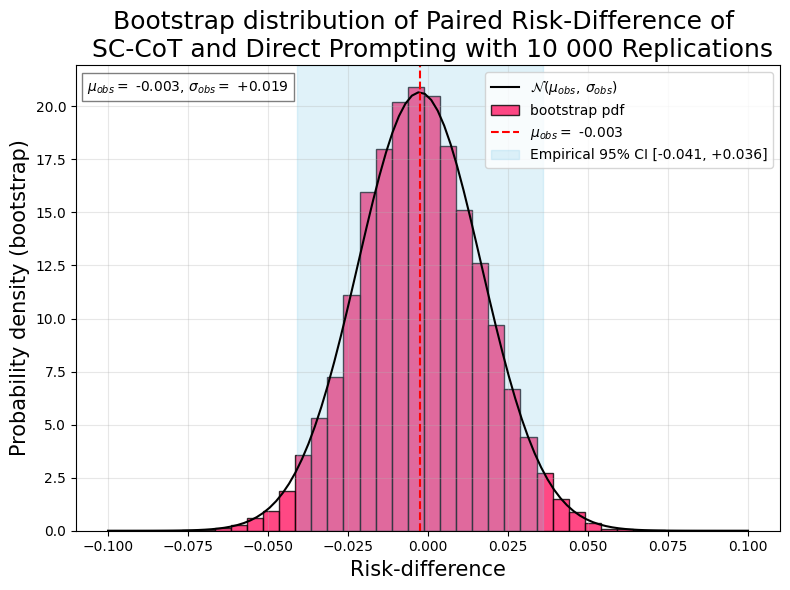

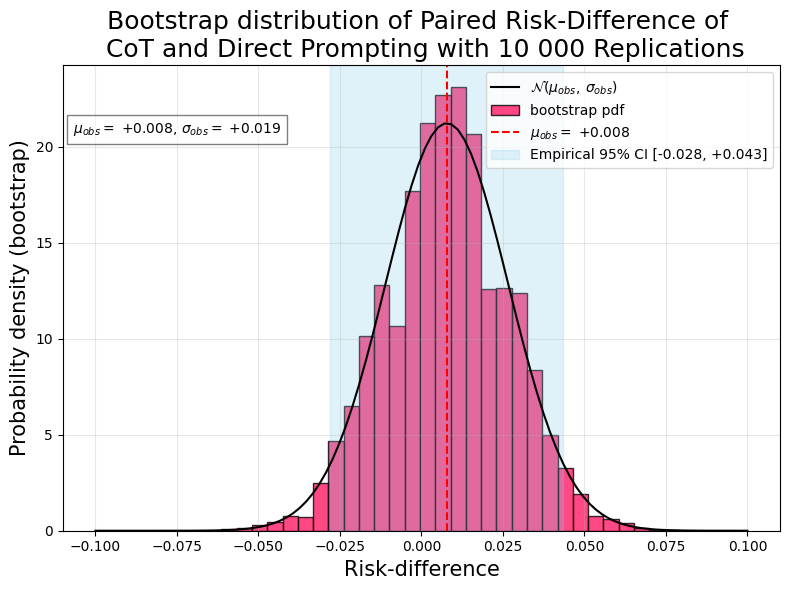

In [ ]:
truth = df.drop_duplicates("snippet_id").set_index("snippet_id")["true_label"]

# correctness matrix (shape 50 × 3, values 0/1)
mat = (df.pivot(index="snippet_id",
                columns="strategy",
                values="pred_label")
         .eq(truth, axis=0).astype(int))

# choose the two strategies you want to compare
A, B, C = "direct", "sc_cot", "cot"      # change 'sc_cot' → 'cot' if desired

# ───────────────────────────────────────────────────────────────────────────────
# 2) Risk-difference and Newcombe 95 % CI (pure Python)
# ───────────────────────────────────────────────────────────────────────────────
from scipy.stats import norm
import math
Z = norm.ppf(0.975)          # 1.96

def wilson_ci(k, n, z=Z):
    if n == 0: return (0,1)
    p = k / n
    denom  = 1 + z**2/n
    centre = (p + z**2/(2*n)) / denom
    half   = z*math.sqrt((p*(1-p) + z**2/(4*n))/n) / denom
    return centre - half, centre + half

def newcombe_ci(k1,n1,k2,n2,z=Z):
    lo1, hi1 = wilson_ci(k1,n1,z)
    lo2, hi2 = wilson_ci(k2,n2,z)
    return lo2 - hi1, hi2 - lo1

n       = len(mat)
a_corr  = mat[A];   b_corr  = mat[B]; c_corr  = mat[C]

ci_lo, ci_hi = newcombe_ci(b_corr.sum(), n, a_corr.sum(), n)

# ───────────────────────────────────────────────────────────────────────────────
# 3) Exact McNemar p-value
# ───────────────────────────────────────────────────────────────────────────────
x01 = int(((a_corr==0)&(b_corr==1)).sum())   # A wrong, B right
x10 = int(((a_corr==1)&(b_corr==0)).sum())   # A right, B wrong
b = x01 + x10
p_mcnemar = (1.0 if b==0 else
             2*sum(math.comb(b,i)*0.5**b for i in range(0, min(x01,x10)+1)))

# ───────────────────────────────────────────────────────────────────────────────
# 4) Bootstrap distribution of risk-difference (10 000 resamples)
# ───────────────────────────────────────────────────────────────────────────────
# --- Bootstrap sampling -------------------------------------------------------
rng = np.random.default_rng(0)
boots = [
    b_corr.iloc[rng.integers(0, n, n)].mean()
  - a_corr.iloc[rng.integers(0, n, n)].mean()
    for _ in range(10_000)
]

# --- 95 % empirical CI --------------------------------------------------------
ci_lo, ci_hi = np.percentile(boots, [2.5, 97.5])

# --- Plot ---------------------------------------------------------------------
plt.figure(figsize=(8,6))
[mu, sig] = (np.mean(boots), np.std(boots))
x = np.linspace(-0.1,
                0.1, 100)
y = norm.pdf(x, mu, sig)

plt.plot(x, norm.pdf(x, mu, sig),
       'k', alpha=1, label='$\mathcal{N}(\mu_{obs}, \: \sigma_{obs})$')
plt.hist(boots, bins=30, density=True, color=(1,0.1,0.4),
         edgecolor="k", alpha=0.8, label="bootstrap pdf")

# observed diff
txt = rf"$\mu_{{obs}} = $ {mu:+.3f}"
plt.axvline(mu, ls="--", color="red", label=txt)
txt += f", $\sigma_{{obs}} = $ {sig:+.3f}"
# 95 % CI band
plt.axvspan(ci_lo, ci_hi, color="skyblue", alpha=0.25,
            label=f"Empirical 95% CI [{ci_lo:+.3f}, {ci_hi:+.3f}]")

plt.xlabel("Risk-difference", fontsize=15)
plt.ylabel("Probability density (bootstrap)", fontsize=15)
plt.title("Bootstrap distribution of Paired Risk-Difference of \n SC-CoT and Direct Prompting with 10 000 Replications", fontsize=18)
plt.text(-0.075, 20.9, txt, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5))
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()



boots_2 = [
    c_corr.iloc[rng.integers(0, n, n)].mean()
  - a_corr.iloc[rng.integers(0, n, n)].mean()
    for _ in range(10_000)
]

# --- 95 % empirical CI --------------------------------------------------------
ci_lo, ci_hi = np.percentile(boots_2, [2.5, 97.5])

# --- Plot ---------------------------------------------------------------------
plt.figure(figsize=(8,6))
[mu, sig] = (np.mean(boots_2), np.std(boots_2))
x = np.linspace(-0.1,
                0.1, 100)
y = norm.pdf(x, mu, sig)

plt.plot(x, norm.pdf(x, mu, sig),
       'k', alpha=1, label='$\mathcal{N}(\mu_{obs}, \: \sigma_{obs})$')
plt.hist(boots_2, bins=30, density=True, color=(1,0.1,0.4),
         edgecolor="k", alpha=0.8, label="bootstrap pdf")

# observed diff
txt = rf"$\mu_{{obs}} = $ {mu:+.3f}"
plt.axvline(mu, ls="--", color="red", label=txt)
txt += f", $\sigma_{{obs}} = $ {sig:+.3f}"
# 95 % CI band
plt.axvspan(ci_lo, ci_hi, color="skyblue", alpha=0.25,
            label=f"Empirical 95% CI [{ci_lo:+.3f}, {ci_hi:+.3f}]")

plt.xlabel("Risk-difference", fontsize=15)
plt.ylabel("Probability density (bootstrap)", fontsize=15)
plt.title("Bootstrap distribution of Paired Risk-Difference of \n CoT and Direct Prompting with 10 000 Replications", fontsize=18)
plt.text(-0.075, 20.9, txt, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5))
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
z = norm.ppf(0.975)

sc = df[df["strategy"] == "sc_cot"]
cot = df[df["strategy"] == "cot"]
direct = df[df["strategy"] == "direct"]
sc_correct = (sc["true_label"] == sc["pred_label"]).sum()
cot_correct = (cot["true_label"] == cot["pred_label"]).sum()
direct_correct = (direct["true_label"] == direct["pred_label"]).sum()
sc_total = len(sc)
cot_total = len(cot)
direct_total = len(direct)


print(f"SC-CoT correct: {sc_correct}")
print(f"SC-CoT total: {sc_total}")
print(f"SC-CoT accuracy: {sc_correct/sc_total}")
print(f"CoT correct: {cot_correct}")
print(f"CoT total: {cot_total}")
print(f"CoT accuracy: {cot_correct/cot_total}")
print(f"Direct correct: {direct_correct}")
print(f"Direct total: {direct_total}")
print(f"Direct accuracy: {direct_correct/direct_total}")

SC_CI = wilson_ci(sc_correct, sc_total, z)
CoT_CI = wilson_ci(cot_correct, cot_total, z)
Direct_CI = wilson_ci(direct_correct, direct_total, z)

print(f"SC-CoT 95% CI: {SC_CI}")
print(f"CoT 95% CI: {CoT_CI}")
print(f"Direct 95% CI: {Direct_CI}")

SC-CoT correct: 359
SC-CoT total: 391
SC-CoT accuracy: 0.9181585677749361
CoT correct: 363
CoT total: 391
CoT accuracy: 0.928388746803069
Direct correct: 360
Direct total: 391
Direct accuracy: 0.9207161125319693
SC-CoT 95% CI: (np.float64(0.8867474261421434), np.float64(0.9414330819956752))
CoT 95% CI: (np.float64(0.898448967794005), np.float64(0.9499928371789895))
Direct 95% CI: (np.float64(0.8896607224239609), np.float64(0.9435851099226517))


In [ ]:
truth = df.drop_duplicates("snippet_id").set_index("snippet_id")["true_label"]

# choose the two strategies you want to compare
A, C = "direct", "cot"      # change 'sc_cot' → 'cot' if desired

Z = norm.ppf(0.975)          # 1.96


n       = len(mat)
a_corr  = mat[A];   c_corr  = mat[C]



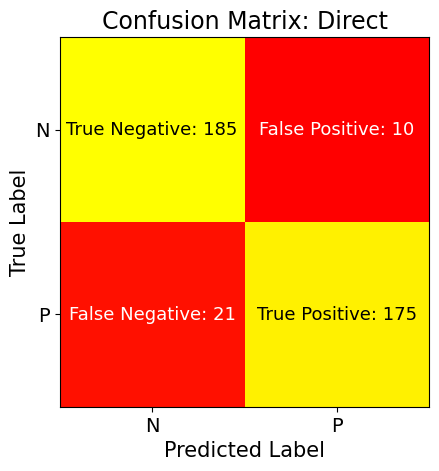

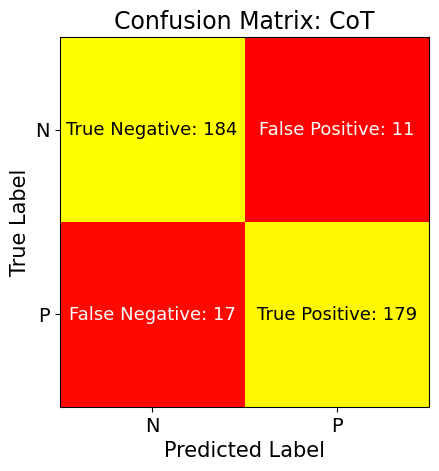

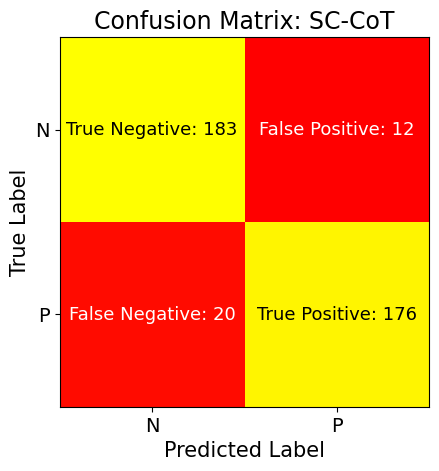

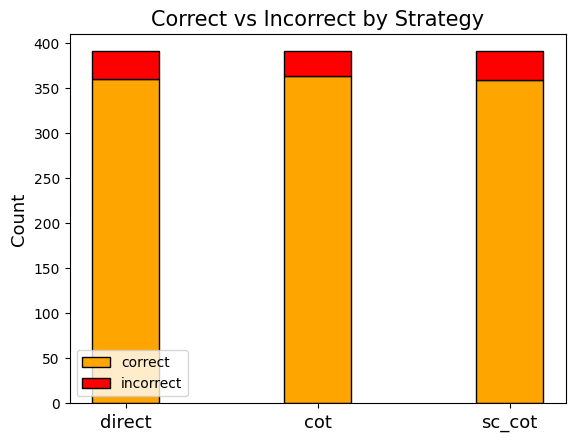

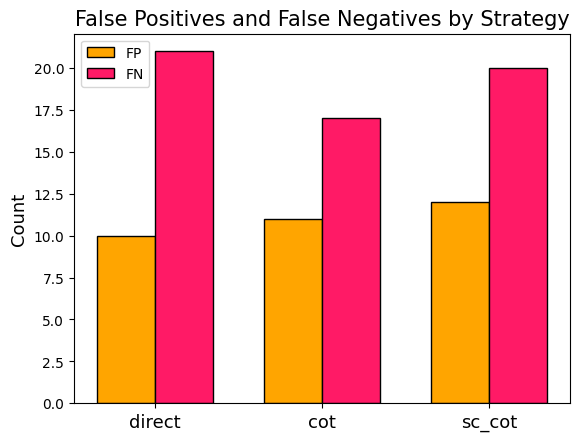

Misclassification patterns found:
cot,direct,sc_cot: 21
direct,sc_cot: 4
cot: 2
sc_cot: 3
direct: 5
cot,sc_cot: 4
cot,direct: 1

Venn diagram counts: {'100': 5, '010': 2, '001': 3, '110': 1, '101': 4, '011': 4, '111': 21}
Total misclassified snippets: 40


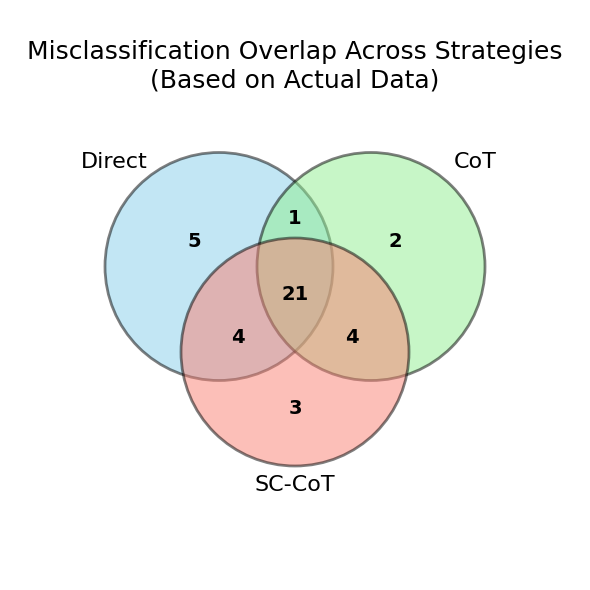

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
from statsmodels.stats.contingency_tables import mcnemar
from matplotlib.patches import Circle

filepath = "C:/Users/Noor/Desktop/159_new/results/summary.csv"
# Load data
df = pd.read_csv(filepath)

# Count how many strategies each snippet has
strategy_counts = df.groupby('snippet_id')['strategy'].nunique()

# Keep only snippet_ids present in all 3 strategies
valid_ids = strategy_counts[strategy_counts == 3].index

# Filter the DataFrame to those valid snippet_ids
df = df[df['snippet_id'].isin(valid_ids)].reset_index(drop=True)

# Now df contains only snippet_ids with classifications for direct, cot, and sc_cot.

# 1. Confusion matrices per strategy
strategies = ['direct', 'cot', 'sc_cot']
label = ["Direct", "CoT", "SC-CoT"]
figures = {}
for i, strat in enumerate(strategies):
    sub = df[df['strategy'] == strat]
    cm = confusion_matrix(sub['true_label'], sub['pred_label'])

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap="autumn")
    plt.title(f'Confusion Matrix: {label[i]}', fontsize=17)
    plt.xticks([0, 1], ['N', 'P'], fontsize=14)
    plt.yticks([0, 1], ['N', 'P'], fontsize=14)
    plt.xlabel('Predicted Label', fontsize=15)
    plt.ylabel('True Label', fontsize=15)

    # Annotate matrix cells
    for (i, j), val in np.ndenumerate(cm):
        match i, j:
            case 0, 0:
                txt = f'True Negative: {val}'
                plt.text(j, i, txt, ha='center', va='center', color='black', fontsize=13)
            case 1, 1:
                txt = f'True Positive: {val}'
                plt.text(j, i, txt, ha='center', va='center', color='black', fontsize=13)
            case 1, 0:
                txt = f'False Negative: {val}'
                plt.text(j, i, txt, ha='center', va='center', color='white', fontsize=13)
            case 0, 1:
                txt = f'False Positive: {val}'
                plt.text(j, i, txt, ha='center', va='center', color='white', fontsize=13)

    plt.show()

# 2. Stacked Bar chart of accuracies
width = 0.35
counts = {}
for strat in strategies:
    sub = df[df.strategy == strat]
    correct = (sub.true_label == sub.pred_label).sum()
    total = len(sub)
    incorrect = total - correct
    counts[strat] = {'correct': correct, 'incorrect': incorrect}

fig, ax = plt.subplots()
x = np.arange(len(strategies))
corrects = [counts[s]['correct'] for s in strategies]
incorrects = [counts[s]['incorrect'] for s in strategies]
ax.bar(x, corrects, width, label='correct', color='orange', edgecolor="k")
ax.bar(x, incorrects, width, bottom=corrects, label='incorrect', color='red', edgecolor="k")
ax.set_xticks(x)
ax.set_xticklabels(strategies, fontsize=13)
ax.set_ylabel('Count', fontsize=13)
ax.set_title('Correct vs Incorrect by Strategy', fontsize=15)
ax.legend()
plt.show()

# 3. Grouped bar: False Positives vs False Negatives
fp = []
fn = []
for strat in strategies:
    sub = df[df.strategy == strat]
    cm = confusion_matrix(sub.true_label, sub.pred_label)
    tn, fp_count, fn_count, tp = cm.ravel()
    fp.append(fp_count)
    fn.append(fn_count)

fig, ax = plt.subplots()
x = np.arange(len(strategies))
ax.bar(x - width/2, fp, width, label='FP', color='orange', edgecolor="k")
ax.bar(x + width/2, fn, width, label='FN', color=(1,0.1,0.4), edgecolor="k")
ax.set_xticks(x)
ax.set_xticklabels(strategies, fontsize=13)
ax.set_ylabel('Count', fontsize=13)
ax.set_title('False Positives and False Negatives by Strategy', fontsize=15)
ax.legend()
plt.show()

# 4. FIXED VENN DIAGRAM - Calculate actual misclassification overlaps
# Group by snippet_id to find which strategies misclassified each snippet
misclassification_patterns = {}

for snippet_id in df['snippet_id'].unique():
    snippet_data = df[df['snippet_id'] == snippet_id]
    
    # Find which strategies misclassified this snippet
    misclassified_by = []
    for _, row in snippet_data.iterrows():
        if row['true_label'] != row['pred_label']:
            misclassified_by.append(row['strategy'])
    
    # Only count snippets that had at least one misclassification
    if misclassified_by:
        # Sort for consistent pattern matching
        pattern = ','.join(sorted(misclassified_by))
        misclassification_patterns[pattern] = misclassification_patterns.get(pattern, 0) + 1

print("Misclassification patterns found:")
for pattern, count in misclassification_patterns.items():
    print(f"{pattern}: {count}")

# Convert to Venn diagram counts
venn_counts = {
    '100': misclassification_patterns.get('direct', 0),           # Direct only
    '010': misclassification_patterns.get('cot', 0),              # CoT only  
    '001': misclassification_patterns.get('sc_cot', 0),           # SC-CoT only
    '110': misclassification_patterns.get('cot,direct', 0),       # Direct & CoT
    '101': misclassification_patterns.get('direct,sc_cot', 0),    # Direct & SC-CoT
    '011': misclassification_patterns.get('cot,sc_cot', 0),       # CoT & SC-CoT
    '111': misclassification_patterns.get('cot,direct,sc_cot', 0) # All three
}

print(f"\nVenn diagram counts: {venn_counts}")
print(f"Total misclassified snippets: {sum(venn_counts.values())}")

# Create the Venn diagram with actual data
fig, ax = plt.subplots(figsize=(6,6))

# Circle parameters
coords = {'Direct': (-1.90, 1.40), 'CoT': (1.90, 1.40), 'SC-CoT': (0, -2.0)}
centers = {'Direct': (-0.8, 0.3), 'CoT': (0.8, 0.3), 'SC-CoT': (0, -0.6)}
radius = 1.2

# Draw circles
colors = {'Direct': 'skyblue', 'CoT': 'lightgreen', 'SC-CoT': 'salmon'}
for name, center in centers.items():
    circ = Circle(center, radius=radius, alpha=0.5, linewidth=2,
                  edgecolor='black', facecolor=colors[name])
    ax.add_patch(circ)


#sum up 
# Coordinates for labels
label_coords = {
    '100': (-1.06, 0.56),    # Direct only
    '010': (1.06, 0.56),     # CoT only
    '001': (0, -1.2),        # SC-CoT only
    '110': (0, 0.8),         # Direct & CoT
    '101': (-0.6, -0.45),    # Direct & SC-CoT
    '011': (0.6, -0.45),     # CoT & SC-CoT
    '111': (0, 0)            # All three
}

# Place actual counts from data
for key, count in venn_counts.items():
    x, y = label_coords[key]
    ax.text(x, y, str(count), ha='center', va='center', fontsize=14, fontweight='bold')

# Place set labels
for name in coords.keys():
    ax.text(coords[name][0], coords[name][1], name, ha='center', va='center', fontsize=16)

ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.axis('off')
ax.set_title(
    'Misclassification Overlap Across Strategies',
    fontsize=18,
    y=0.85

)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.stats.contingency_tables import mcnemar
from scipy.stats import chi2_contingency

filepath = "C:/Users/Noor/Desktop/159_new/results/summary.csv"
# Load data
df = pd.read_csv(filepath)

# Count how many strategies each snippet has
strategy_counts = df.groupby('snippet_id')['strategy'].nunique()

# Pivot data to have one row per snippet with columns for each strategy's prediction
pivot_df = df.pivot(index='snippet_id', columns='strategy', values='pred_label')
true_labels = df.groupby('snippet_id')['true_label'].first()

# Add true labels to pivot
pivot_df['true_label'] = true_labels

print("\nFirst few rows of pivoted data:")
print(pivot_df.head())

# Function to create confusion matrix for McNemar test
def create_mcnemar_table(strategy1_correct, strategy2_correct):
    """
    Create 2x2 contingency table for McNemar test
    
    Returns:
        [[both_correct, strategy1_correct_only],
         [strategy2_correct_only, both_wrong]]
    """
    both_correct = np.sum(strategy1_correct & strategy2_correct)
    strategy1_only = np.sum(strategy1_correct & ~strategy2_correct)
    strategy2_only = np.sum(~strategy1_correct & strategy2_correct)
    both_wrong = np.sum(~strategy1_correct & ~strategy2_correct)
    
    return np.array([[both_correct, strategy1_only],
                     [strategy2_only, both_wrong]])

# Calculate correctness for each strategy
direct_correct = (pivot_df['direct'] == pivot_df['true_label'])
cot_correct = (pivot_df['cot'] == pivot_df['true_label'])
sc_cot_correct = (pivot_df['sc_cot'] == pivot_df['true_label'])

print(f"\nAccuracy rates:")
print(f"Direct: {direct_correct.mean():.4f}")
print(f"CoT: {cot_correct.mean():.4f}")
print(f"SC-CoT: {sc_cot_correct.mean():.4f}")

# McNemar Test 1: CoT vs SC-CoT
print("\n" + "="*50)
print("McNemar Test: CoT vs SC-CoT")
print("="*50)

mcnemar_table_cot_sc = create_mcnemar_table(cot_correct, sc_cot_correct)
print("Contingency Table (CoT vs SC-CoT):")
print("                    SC-CoT")
print("                Correct  Incorrect")
print(f"CoT Correct       {mcnemar_table_cot_sc[0,0]:3d}      {mcnemar_table_cot_sc[0,1]:3d}")
print(f"CoT Incorrect     {mcnemar_table_cot_sc[1,0]:3d}      {mcnemar_table_cot_sc[1,1]:3d}")

# Perform McNemar test
result_cot_sc = mcnemar(mcnemar_table_cot_sc, exact=True)
print(f"\nMcNemar Test Results:")
print(f"Test statistic: {result_cot_sc.statistic:.4f}")
print(f"P-value: {result_cot_sc.pvalue:.6f}")

if result_cot_sc.pvalue < 0.05:
    print("Result: Significant difference (p < 0.05)")
else:
    print("Result: No significant difference (p >= 0.05)")

# McNemar Test 2: Direct vs CoT
print("\n" + "="*50)
print("McNemar Test: Direct vs CoT")
print("="*50)

mcnemar_table_direct_cot = create_mcnemar_table(direct_correct, cot_correct)
print("Contingency Table (Direct vs CoT):")
print("                      CoT")
print("                Correct  Incorrect")
print(f"Direct Correct    {mcnemar_table_direct_cot[0,0]:3d}      {mcnemar_table_direct_cot[0,1]:3d}")
print(f"Direct Incorrect  {mcnemar_table_direct_cot[1,0]:3d}      {mcnemar_table_direct_cot[1,1]:3d}")

# Perform McNemar test
result_direct_cot = mcnemar(mcnemar_table_direct_cot, exact=True)
print(f"\nMcNemar Test Results:")
print(f"Test statistic: {result_direct_cot.statistic:.4f}")
print(f"P-value: {result_direct_cot.pvalue:.6f}")

if result_direct_cot.pvalue < 0.05:
    print("Result: Significant difference (p < 0.05)")
else:
    print("Result: No significant difference (p >= 0.05)")

# Bonus: Direct vs SC-CoT
print("\n" + "="*50)
print("McNemar Test: Direct vs SC-CoT")
print("="*50)

mcnemar_table_direct_sc = create_mcnemar_table(cot_correct, sc_cot_correct)
print("Contingency Table (Direct vs SC-CoT):")
print("                    SC-CoT")
print("                Correct  Incorrect")
print(f"Direct Correct    {mcnemar_table_direct_sc[0,0]:3d}      {mcnemar_table_direct_sc[0,1]:3d}")
print(f"Direct Incorrect  {mcnemar_table_direct_sc[1,0]:3d}      {mcnemar_table_direct_sc[1,1]:3d}")

# Perform McNemar test
result_direct_sc = mcnemar(mcnemar_table_direct_sc, exact=True)
print(f"\nMcNemar Test Results:")
print(f"Test statistic: {result_direct_sc.statistic:.4f}")
print(f"P-value: {result_direct_sc.pvalue:.6f}")

if result_direct_sc.pvalue < 0.05:
    print("Result: Significant difference (p < 0.05)")
else:
    print("Result: No significant difference (p >= 0.05)")

# Summary of all results
print("\n" + "="*60)
print("SUMMARY OF ALL McNEMAR TESTS")
print("="*60)
print(f"CoT vs SC-CoT:     p = {result_cot_sc.pvalue:.6f}")
print(f"Direct vs CoT:     p = {result_direct_cot.pvalue:.6f}")
print(f"CoT vs SC-CoT:  p = {result_direct_sc.pvalue:.6f}")
print("\nSignificance threshold: p < 0.05")


First few rows of pivoted data:
strategy         cot    direct    sc_cot true_label
snippet_id                                         
0           negative  negative  negative   positive
1           positive  positive  positive   positive
2           positive  positive  positive   positive
3           positive  positive  positive   positive
4           positive  positive  positive   positive

Accuracy rates:
Direct: 0.9075
CoT: 0.9175
SC-CoT: 0.8975

McNemar Test: CoT vs SC-CoT
Contingency Table (CoT vs SC-CoT):
                    SC-CoT
                Correct  Incorrect
CoT Correct       356       11
CoT Incorrect       3       30

McNemar Test Results:
Test statistic: 3.0000
P-value: 0.057373
Result: No significant difference (p >= 0.05)

McNemar Test: Direct vs CoT
Contingency Table (Direct vs CoT):
                      CoT
                Correct  Incorrect
Direct Correct    357        6
Direct Incorrect   10       27

McNemar Test Results:
Test statistic: 6.0000
P-value: 0.45

First few rows of pivoted data:
strategy         cot    direct    sc_cot true_label
snippet_id                                         
0           negative  negative  negative   positive
1           positive  positive  positive   positive
2           positive  positive  positive   positive
3           positive  positive  positive   positive
4           positive  positive  positive   positive

Accuracy rates:
Direct: 0.9207
CoT: 0.9284
SC-CoT: 0.9182
ANALYZING: CoT vs SC-CoT

COMPREHENSIVE ANALYSIS: CoT vs SC-CoT
Contingency Table (CoT vs SC-CoT):
                    SC-CoT
                Correct  Incorrect
CoT Correct       356        7
CoT Incorrect       3       25

Original McNemar Test Results:
Test statistic: 3.0000
P-value: 0.343750
Result: No significant difference (p >= 0.05)

--------------------------------------------------
TEST 1: ONE-TAILED McNEMAR TEST
--------------------------------------------------
One-tailed p-value: 0.171875
Not significant with one-tailed test

-

ACCURACY RATES:
Direct accuracy: 0.9207
CoT accuracy: 0.9284
SC-CoT accuracy: 0.9182
RUNNING COMPREHENSIVE ANALYSIS FOR BOTH COMPARISONS

ANALYSIS: CoT vs SC-CoT

Contingency Table (CoT vs SC-CoT):
                    SC-CoT
                Correct  Incorrect
CoT Correct    356        7
CoT Incorrect    3       25

Original McNemar p-value: 0.343750

----------------------------------------
APPROACH 1: ONE-TAILED TEST
----------------------------------------
One-tailed p-value: 0.171875
Still not significant with one-tailed test

----------------------------------------
APPROACH 2: EXACT BINOMIAL TEST
----------------------------------------
Cases where CoT correct, SC-CoT wrong: 7
Cases where SC-CoT correct, CoT wrong: 3
Total disagreements: 10
Binomial test (two-tailed): p = 0.343750
Binomial test (one-tailed): p = 0.171875
Not significant with binomial test

----------------------------------------
APPROACH 3: BOOTSTRAP CONFIDENCE INTERVAL
----------------------------------------
Ob

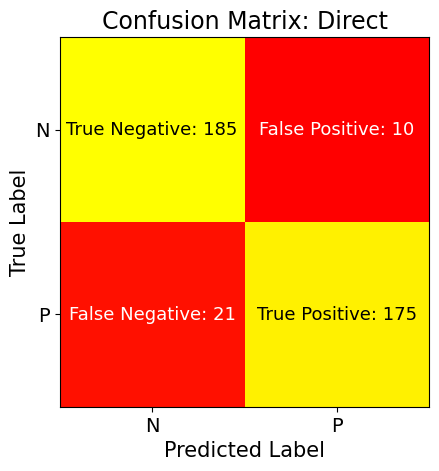

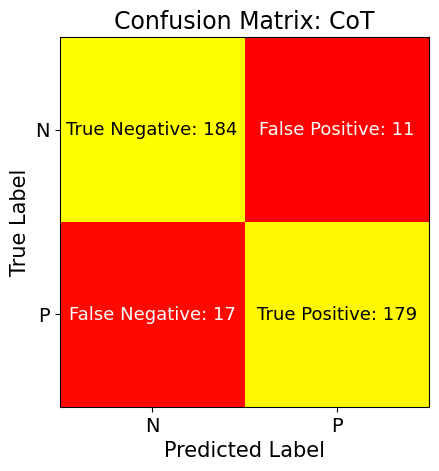

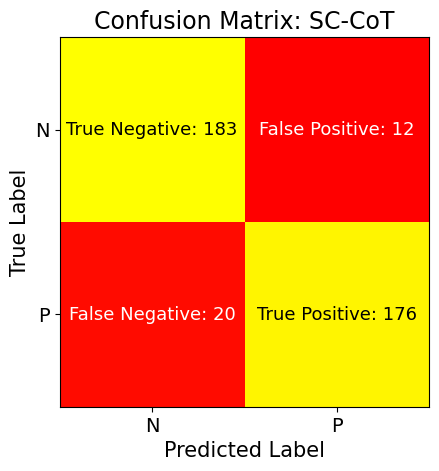

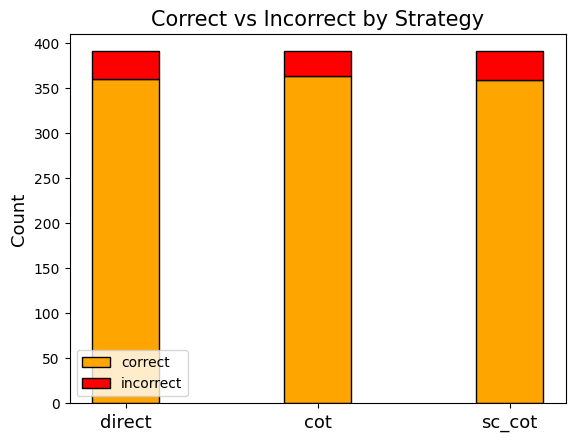

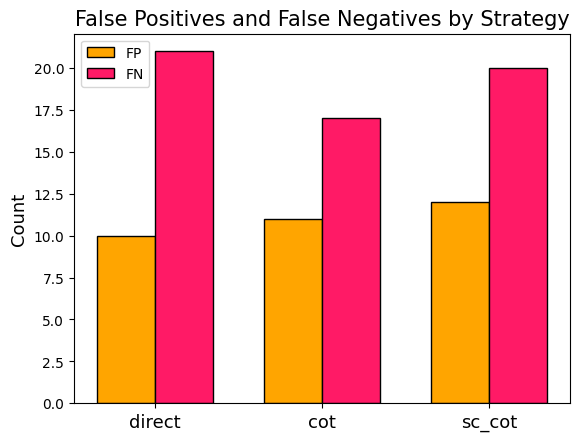

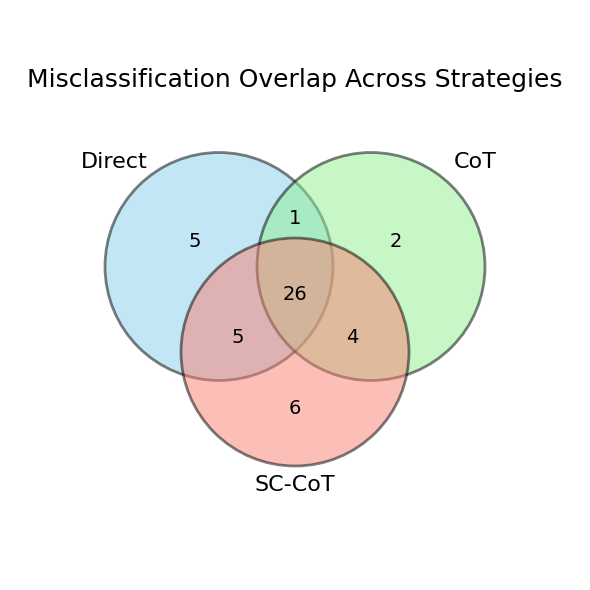

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
from statsmodels.stats.contingency_tables import mcnemar
filepath = "C:/Users/Noor/Desktop/159_new/results/summary.csv"
# Load data
df = pd.read_csv(filepath)

# Count how many strategies each snippet has
strategy_counts = df.groupby('snippet_id')['strategy'].nunique()

# Keep only snippet_ids present in all 3 strategies
valid_ids = strategy_counts[strategy_counts == 3].index

# Filter the DataFrame to those valid snippet_ids
df = df[df['snippet_id'].isin(valid_ids)].reset_index(drop=True)

# Now df contains only snippet_ids with classifications for direct, cot, and sc_cot.


# 1. Confusion matrices per strategy
strategies = ['direct', 'cot', 'sc_cot']
label = ["Direct", "CoT", "SC-CoT"]
figures = {}
for i, strat in enumerate(strategies):
    sub = df[df['strategy'] == strat]
    cm = confusion_matrix(sub['true_label'], sub['pred_label'])

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap="autumn")
    plt.title(f'Confusion Matrix: {label[i]}', fontsize=17)
    plt.xticks([0, 1], ['N', 'P'], fontsize=14)
    plt.yticks([0, 1], ['N', 'P'], fontsize=14)
    plt.xlabel('Predicted Label', fontsize=15)
    plt.ylabel('True Label', fontsize=15)

    # Annotate matrix cells
    for (i, j), val in np.ndenumerate(cm):
        match i, j:
            case 0, 0:
                txt = f'True Negative: {val}'
                plt.text(j, i, txt, ha='center', va='center', color='black', fontsize=13)
            case 1, 1:
                txt = f'True Positive: {val}'
                plt.text(j, i, txt, ha='center', va='center', color='black', fontsize=13)
            case 1, 0:
                txt = f'False Negative: {val}'
                plt.text(j, i, txt, ha='center', va='center', color='white', fontsize=13)
            case 0, 1:
                txt = f'False Positive: {val}'
                plt.text(j, i, txt, ha='center', va='center', color='white', fontsize=13)

    plt.show()

# 2. Stacked Bar chart of accuracies
width = 0.35
counts = {}
for strat in strategies:
    sub = df[df.strategy == strat]
    correct = (sub.true_label == sub.pred_label).sum()
    total = len(sub)
    incorrect = total - correct
    counts[strat] = {'correct': correct, 'incorrect': incorrect}

fig, ax = plt.subplots()
x = np.arange(len(strategies))
corrects = [counts[s]['correct'] for s in strategies]
incorrects = [counts[s]['incorrect'] for s in strategies]
ax.bar(x, corrects, width, label='correct', color='orange', edgecolor="k")
ax.bar(x, incorrects, width, bottom=corrects, label='incorrect', color='red', edgecolor="k")
ax.set_xticks(x)
ax.set_xticklabels(strategies, fontsize=13)
ax.set_ylabel('Count', fontsize=13)
ax.set_title('Correct vs Incorrect by Strategy', fontsize=15)
ax.legend()
plt.show()

# 3. Grouped bar: False Positives vs False Negatives
fp = []
fn = []
for strat in strategies:
    sub = df[df.strategy == strat]
    cm = confusion_matrix(sub.true_label, sub.pred_label)
    tn, fp_count, fn_count, tp = cm.ravel()
    fp.append(fp_count)
    fn.append(fn_count)

fig, ax = plt.subplots()
x = np.arange(len(strategies))
ax.bar(x - width/2, fp, width, label='FP', color='orange', edgecolor="k")
ax.bar(x + width/2, fn, width, label='FN', color=(1,0.1,0.4), edgecolor="k")
ax.set_xticks(x)
ax.set_xticklabels(strategies, fontsize=13)
ax.set_ylabel('Count', fontsize=13)
ax.set_title('False Positives and False Negatives by Strategy', fontsize=15)
ax.legend()
plt.show()

from matplotlib_venn import venn3, venn3_circles
from matplotlib.patches import Circle

# Pivot to wide format
fig, ax = plt.subplots(figsize=(6,6))

# Circle parameters
coords = {'Direct': (-1.90, 1.40), 'CoT': (1.90, 1.40), 'SC-CoT': (0, -2.0)}
centers = {'Direct': (-0.8, 0.3), 'CoT': (0.8, 0.3), 'SC-CoT': (0, -0.6)}
radius = 1.2

# Draw circles
colors = {'Direct': 'skyblue', 'CoT': 'lightgreen', 'SC-CoT': 'salmon'}
for name, center in centers.items():
    circ = Circle(center, radius=radius, alpha=0.5, linewidth=2,
                  edgecolor='black', facecolor=colors[name])
    ax.add_patch(circ)

# Subset counts
counts = {
    '100': 5,   # Direct only
    '010': 2,   # CoT only
    '001': 6,   # SC-CoT only
    '110': 1,   # Direct & CoT
    '101': 5,   # Direct & SC-CoT
    '011': 4,   # CoT & SC-CoT
    '111': 26   # All three
}
# Coordinates for labels
label_coords = {
    '100': (-1.06, 0.56),
    '010': (1.06, 0.56),
    '001': (0, -1.2),
    '110': (0, 0.8),
    '101': (-0.6, -0.45),
    '011': (0.6, -0.45),
    '111': (0, 0)
}


# Place counts
for key, count in counts.items():
    x, y = label_coords[key]
    ax.text(x, y, str(count), ha='center', va='center', fontsize=14)

# Place set labels
for name in coords.keys():
    ax.text(coords[name][0], coords[name][1], name, ha='center', va='center', fontsize=16)

ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.axis('off')
ax.set_title(
    'Misclassification Overlap Across Strategies',
    fontsize=18,
    y=0.85        # default is y=1.00; lower means “bring it down”
)
plt.tight_layout()
plt.show()


<>:68: SyntaxWarning: invalid escape sequence '\m'
<>:75: SyntaxWarning: invalid escape sequence '\s'
<>:108: SyntaxWarning: invalid escape sequence '\m'
<>:115: SyntaxWarning: invalid escape sequence '\s'
<>:68: SyntaxWarning: invalid escape sequence '\m'
<>:75: SyntaxWarning: invalid escape sequence '\s'
<>:108: SyntaxWarning: invalid escape sequence '\m'
<>:115: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Noor\AppData\Local\Temp\ipykernel_37680\1548924009.py:68: SyntaxWarning: invalid escape sequence '\m'
  'k', alpha=1, label='$\mathcal{N}(\mu_{obs}, \: \sigma_{obs})$')
C:\Users\Noor\AppData\Local\Temp\ipykernel_37680\1548924009.py:75: SyntaxWarning: invalid escape sequence '\s'
  txt += f", $\sigma_{{obs}} = $ {sig:+.3f}"
C:\Users\Noor\AppData\Local\Temp\ipykernel_37680\1548924009.py:108: SyntaxWarning: invalid escape sequence '\m'
  'k', alpha=1, label='$\mathcal{N}(\mu_{obs}, \: \sigma_{obs})$')
C:\Users\Noor\AppData\Local\Temp\ipykernel_37680\1548924009.py:115: SyntaxW

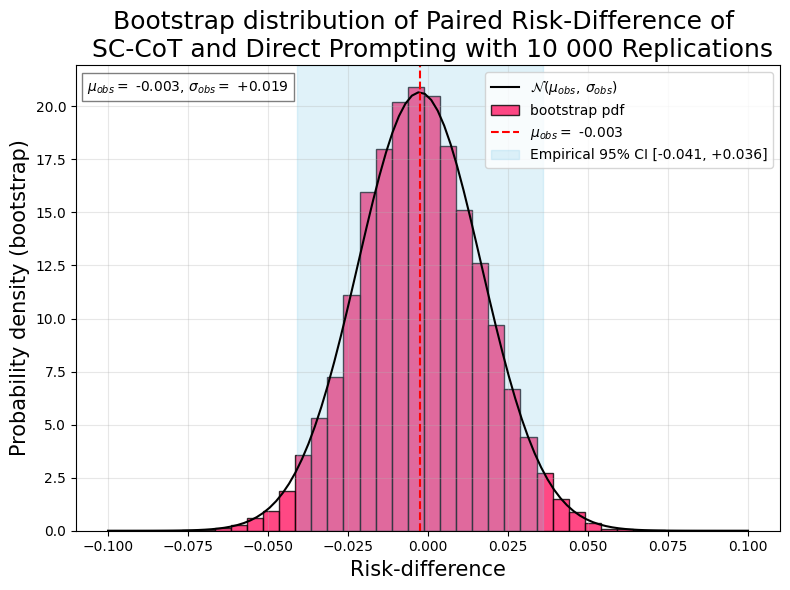

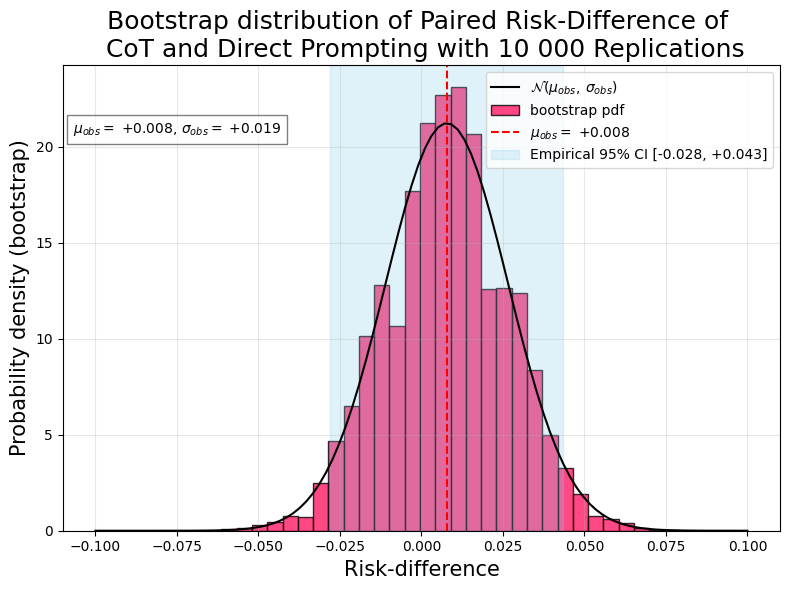

In [ ]:
truth = df.drop_duplicates("snippet_id").set_index("snippet_id")["true_label"]

# correctness matrix (shape 50 × 3, values 0/1)
mat = (df.pivot(index="snippet_id",
                columns="strategy",
                values="pred_label")
         .eq(truth, axis=0).astype(int))

# choose the two strategies you want to compare
A, B, C = "direct", "sc_cot", "cot"      # change 'sc_cot' → 'cot' if desired

# ───────────────────────────────────────────────────────────────────────────────
# 2) Risk-difference and Newcombe 95 % CI (pure Python)
# ───────────────────────────────────────────────────────────────────────────────
from scipy.stats import norm
import math
Z = norm.ppf(0.975)          # 1.96

def wilson_ci(k, n, z=Z):
    if n == 0: return (0,1)
    p = k / n
    denom  = 1 + z**2/n
    centre = (p + z**2/(2*n)) / denom
    half   = z*math.sqrt((p*(1-p) + z**2/(4*n))/n) / denom
    return centre - half, centre + half

def newcombe_ci(k1,n1,k2,n2,z=Z):
    lo1, hi1 = wilson_ci(k1,n1,z)
    lo2, hi2 = wilson_ci(k2,n2,z)
    return lo2 - hi1, hi2 - lo1

n       = len(mat)
a_corr  = mat[A];   b_corr  = mat[B]; c_corr  = mat[C]

ci_lo, ci_hi = newcombe_ci(b_corr.sum(), n, a_corr.sum(), n)

# ───────────────────────────────────────────────────────────────────────────────
# 3) Exact McNemar p-value
# ───────────────────────────────────────────────────────────────────────────────
x01 = int(((a_corr==0)&(b_corr==1)).sum())   # A wrong, B right
x10 = int(((a_corr==1)&(b_corr==0)).sum())   # A right, B wrong
b = x01 + x10
p_mcnemar = (1.0 if b==0 else
             2*sum(math.comb(b,i)*0.5**b for i in range(0, min(x01,x10)+1)))

# ───────────────────────────────────────────────────────────────────────────────
# 4) Bootstrap distribution of risk-difference (10 000 resamples)
# ───────────────────────────────────────────────────────────────────────────────
# --- Bootstrap sampling -------------------------------------------------------
rng = np.random.default_rng(0)
boots = [
    b_corr.iloc[rng.integers(0, n, n)].mean()
  - a_corr.iloc[rng.integers(0, n, n)].mean()
    for _ in range(10_000)
]

# --- 95 % empirical CI --------------------------------------------------------
ci_lo, ci_hi = np.percentile(boots, [2.5, 97.5])

# --- Plot ---------------------------------------------------------------------
plt.figure(figsize=(8,6))
[mu, sig] = (np.mean(boots), np.std(boots))
x = np.linspace(-0.1,
                0.1, 100)
y = norm.pdf(x, mu, sig)

plt.plot(x, norm.pdf(x, mu, sig),
       'k', alpha=1, label='$\mathcal{N}(\mu_{obs}, \: \sigma_{obs})$')
plt.hist(boots, bins=30, density=True, color=(1,0.1,0.4),
         edgecolor="k", alpha=0.8, label="bootstrap pdf")

# observed diff
txt = rf"$\mu_{{obs}} = $ {mu:+.3f}"
plt.axvline(mu, ls="--", color="red", label=txt)
txt += f", $\sigma_{{obs}} = $ {sig:+.3f}"
# 95 % CI band
plt.axvspan(ci_lo, ci_hi, color="skyblue", alpha=0.25,
            label=f"Empirical 95% CI [{ci_lo:+.3f}, {ci_hi:+.3f}]")

plt.xlabel("Risk-difference", fontsize=15)
plt.ylabel("Probability density (bootstrap)", fontsize=15)
plt.title("Bootstrap distribution of Paired Risk-Difference of \n SC-CoT and Direct Prompting with 10 000 Replications", fontsize=18)
plt.text(-0.075, 20.9, txt, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5))
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()



boots_2 = [
    c_corr.iloc[rng.integers(0, n, n)].mean()
  - a_corr.iloc[rng.integers(0, n, n)].mean()
    for _ in range(10_000)
]

# --- 95 % empirical CI --------------------------------------------------------
ci_lo, ci_hi = np.percentile(boots_2, [2.5, 97.5])

# --- Plot ---------------------------------------------------------------------
plt.figure(figsize=(8,6))
[mu, sig] = (np.mean(boots_2), np.std(boots_2))
x = np.linspace(-0.1,
                0.1, 100)
y = norm.pdf(x, mu, sig)

plt.plot(x, norm.pdf(x, mu, sig),
       'k', alpha=1, label='$\mathcal{N}(\mu_{obs}, \: \sigma_{obs})$')
plt.hist(boots_2, bins=30, density=True, color=(1,0.1,0.4),
         edgecolor="k", alpha=0.8, label="bootstrap pdf")

# observed diff
txt = rf"$\mu_{{obs}} = $ {mu:+.3f}"
plt.axvline(mu, ls="--", color="red", label=txt)
txt += f", $\sigma_{{obs}} = $ {sig:+.3f}"
# 95 % CI band
plt.axvspan(ci_lo, ci_hi, color="skyblue", alpha=0.25,
            label=f"Empirical 95% CI [{ci_lo:+.3f}, {ci_hi:+.3f}]")

plt.xlabel("Risk-difference", fontsize=15)
plt.ylabel("Probability density (bootstrap)", fontsize=15)
plt.title("Bootstrap distribution of Paired Risk-Difference of \n CoT and Direct Prompting with 10 000 Replications", fontsize=18)
plt.text(-0.075, 20.9, txt, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5))
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
z = norm.ppf(0.975)

sc = df[df["strategy"] == "sc_cot"]
cot = df[df["strategy"] == "cot"]
direct = df[df["strategy"] == "direct"]
sc_correct = (sc["true_label"] == sc["pred_label"]).sum()
cot_correct = (cot["true_label"] == cot["pred_label"]).sum()
direct_correct = (direct["true_label"] == direct["pred_label"]).sum()
sc_total = len(sc)
cot_total = len(cot)
direct_total = len(direct)


print(f"SC-CoT correct: {sc_correct}")
print(f"SC-CoT total: {sc_total}")
print(f"SC-CoT accuracy: {sc_correct/sc_total}")
print(f"CoT correct: {cot_correct}")
print(f"CoT total: {cot_total}")
print(f"CoT accuracy: {cot_correct/cot_total}")
print(f"Direct correct: {direct_correct}")
print(f"Direct total: {direct_total}")
print(f"Direct accuracy: {direct_correct/direct_total}")

SC_CI = wilson_ci(sc_correct, sc_total, z)
CoT_CI = wilson_ci(cot_correct, cot_total, z)
Direct_CI = wilson_ci(direct_correct, direct_total, z)

print(f"SC-CoT 95% CI: {SC_CI}")
print(f"CoT 95% CI: {CoT_CI}")
print(f"Direct 95% CI: {Direct_CI}")

SC-CoT correct: 359
SC-CoT total: 391
SC-CoT accuracy: 0.9181585677749361
CoT correct: 363
CoT total: 391
CoT accuracy: 0.928388746803069
Direct correct: 360
Direct total: 391
Direct accuracy: 0.9207161125319693
SC-CoT 95% CI: (np.float64(0.8867474261421434), np.float64(0.9414330819956752))
CoT 95% CI: (np.float64(0.898448967794005), np.float64(0.9499928371789895))
Direct 95% CI: (np.float64(0.8896607224239609), np.float64(0.9435851099226517))


In [ ]:
truth = df.drop_duplicates("snippet_id").set_index("snippet_id")["true_label"]

# choose the two strategies you want to compare
A, C = "direct", "cot"      # change 'sc_cot' → 'cot' if desired

Z = norm.ppf(0.975)          # 1.96


n       = len(mat)
a_corr  = mat[A];   c_corr  = mat[C]



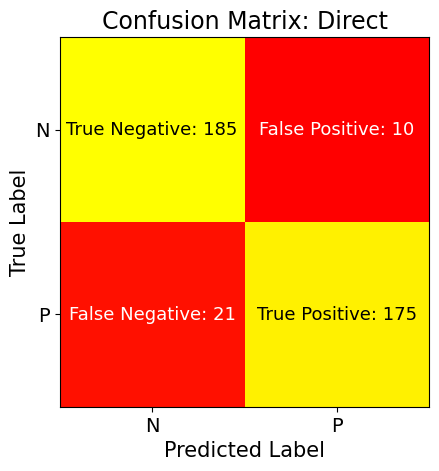

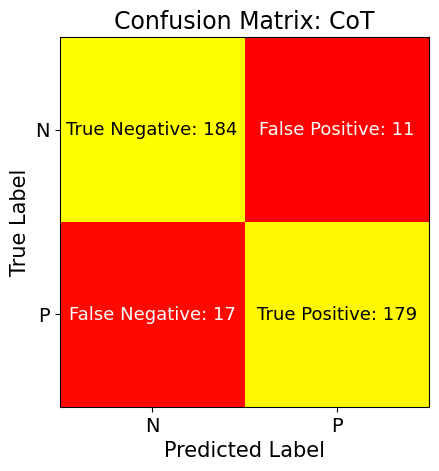

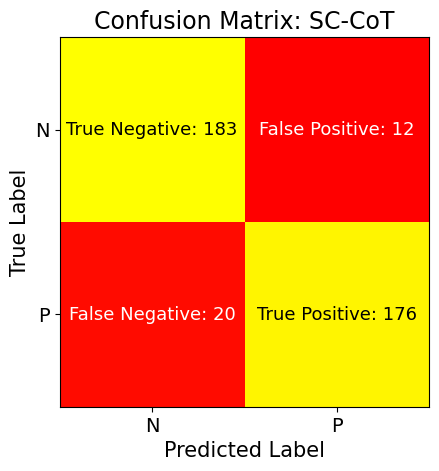

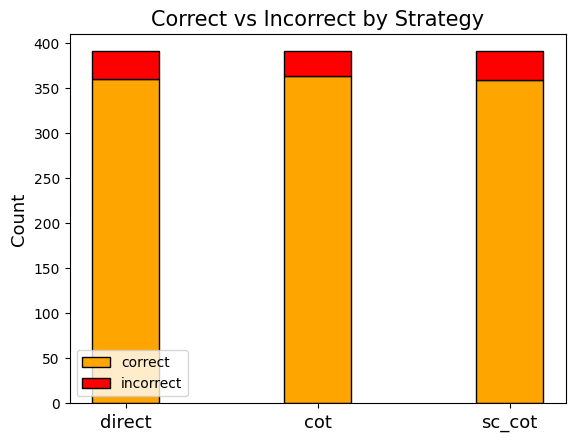

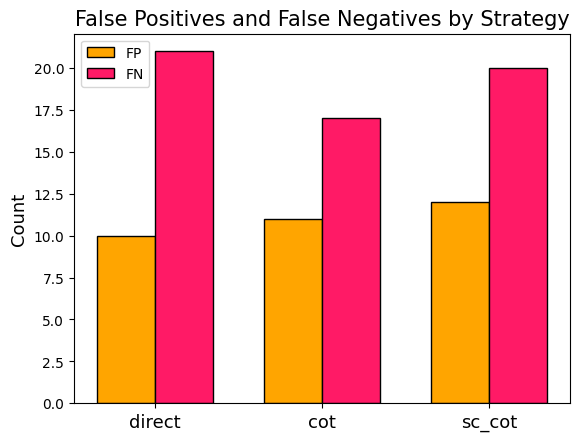

Misclassification patterns found:
cot,direct,sc_cot: 21
direct,sc_cot: 4
cot: 2
sc_cot: 3
direct: 5
cot,sc_cot: 4
cot,direct: 1

Venn diagram counts: {'100': 5, '010': 2, '001': 3, '110': 1, '101': 4, '011': 4, '111': 21}
Total misclassified snippets: 40


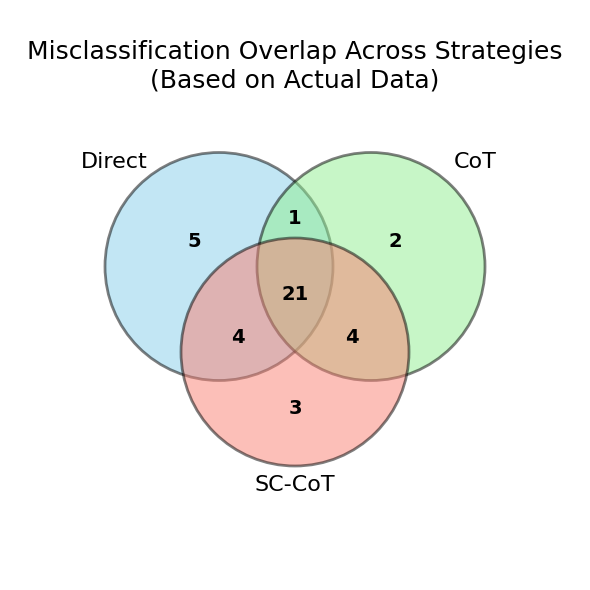

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
from statsmodels.stats.contingency_tables import mcnemar
from matplotlib.patches import Circle

filepath = "C:/Users/Noor/Desktop/159_new/results/summary.csv"
# Load data
df = pd.read_csv(filepath)

# Count how many strategies each snippet has
strategy_counts = df.groupby('snippet_id')['strategy'].nunique()

# Keep only snippet_ids present in all 3 strategies
valid_ids = strategy_counts[strategy_counts == 3].index

# Filter the DataFrame to those valid snippet_ids
df = df[df['snippet_id'].isin(valid_ids)].reset_index(drop=True)

# Now df contains only snippet_ids with classifications for direct, cot, and sc_cot.

# 1. Confusion matrices per strategy
strategies = ['direct', 'cot', 'sc_cot']
label = ["Direct", "CoT", "SC-CoT"]
figures = {}
for i, strat in enumerate(strategies):
    sub = df[df['strategy'] == strat]
    cm = confusion_matrix(sub['true_label'], sub['pred_label'])

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap="autumn")
    plt.title(f'Confusion Matrix: {label[i]}', fontsize=17)
    plt.xticks([0, 1], ['N', 'P'], fontsize=14)
    plt.yticks([0, 1], ['N', 'P'], fontsize=14)
    plt.xlabel('Predicted Label', fontsize=15)
    plt.ylabel('True Label', fontsize=15)

    # Annotate matrix cells
    for (i, j), val in np.ndenumerate(cm):
        match i, j:
            case 0, 0:
                txt = f'True Negative: {val}'
                plt.text(j, i, txt, ha='center', va='center', color='black', fontsize=13)
            case 1, 1:
                txt = f'True Positive: {val}'
                plt.text(j, i, txt, ha='center', va='center', color='black', fontsize=13)
            case 1, 0:
                txt = f'False Negative: {val}'
                plt.text(j, i, txt, ha='center', va='center', color='white', fontsize=13)
            case 0, 1:
                txt = f'False Positive: {val}'
                plt.text(j, i, txt, ha='center', va='center', color='white', fontsize=13)

    plt.show()

# 2. Stacked Bar chart of accuracies
width = 0.35
counts = {}
for strat in strategies:
    sub = df[df.strategy == strat]
    correct = (sub.true_label == sub.pred_label).sum()
    total = len(sub)
    incorrect = total - correct
    counts[strat] = {'correct': correct, 'incorrect': incorrect}

fig, ax = plt.subplots()
x = np.arange(len(strategies))
corrects = [counts[s]['correct'] for s in strategies]
incorrects = [counts[s]['incorrect'] for s in strategies]
ax.bar(x, corrects, width, label='correct', color='orange', edgecolor="k")
ax.bar(x, incorrects, width, bottom=corrects, label='incorrect', color='red', edgecolor="k")
ax.set_xticks(x)
ax.set_xticklabels(strategies, fontsize=13)
ax.set_ylabel('Count', fontsize=13)
ax.set_title('Correct vs Incorrect by Strategy', fontsize=15)
ax.legend()
plt.show()

# 3. Grouped bar: False Positives vs False Negatives
fp = []
fn = []
for strat in strategies:
    sub = df[df.strategy == strat]
    cm = confusion_matrix(sub.true_label, sub.pred_label)
    tn, fp_count, fn_count, tp = cm.ravel()
    fp.append(fp_count)
    fn.append(fn_count)

fig, ax = plt.subplots()
x = np.arange(len(strategies))
ax.bar(x - width/2, fp, width, label='FP', color='orange', edgecolor="k")
ax.bar(x + width/2, fn, width, label='FN', color=(1,0.1,0.4), edgecolor="k")
ax.set_xticks(x)
ax.set_xticklabels(strategies, fontsize=13)
ax.set_ylabel('Count', fontsize=13)
ax.set_title('False Positives and False Negatives by Strategy', fontsize=15)
ax.legend()
plt.show()

# 4. FIXED VENN DIAGRAM - Calculate actual misclassification overlaps
# Group by snippet_id to find which strategies misclassified each snippet
misclassification_patterns = {}

for snippet_id in df['snippet_id'].unique():
    snippet_data = df[df['snippet_id'] == snippet_id]
    
    # Find which strategies misclassified this snippet
    misclassified_by = []
    for _, row in snippet_data.iterrows():
        if row['true_label'] != row['pred_label']:
            misclassified_by.append(row['strategy'])
    
    # Only count snippets that had at least one misclassification
    if misclassified_by:
        # Sort for consistent pattern matching
        pattern = ','.join(sorted(misclassified_by))
        misclassification_patterns[pattern] = misclassification_patterns.get(pattern, 0) + 1

print("Misclassification patterns found:")
for pattern, count in misclassification_patterns.items():
    print(f"{pattern}: {count}")

# Convert to Venn diagram counts
venn_counts = {
    '100': misclassification_patterns.get('direct', 0),           # Direct only
    '010': misclassification_patterns.get('cot', 0),              # CoT only  
    '001': misclassification_patterns.get('sc_cot', 0),           # SC-CoT only
    '110': misclassification_patterns.get('cot,direct', 0),       # Direct & CoT
    '101': misclassification_patterns.get('direct,sc_cot', 0),    # Direct & SC-CoT
    '011': misclassification_patterns.get('cot,sc_cot', 0),       # CoT & SC-CoT
    '111': misclassification_patterns.get('cot,direct,sc_cot', 0) # All three
}

print(f"\nVenn diagram counts: {venn_counts}")
print(f"Total misclassified snippets: {sum(venn_counts.values())}")

# Create the Venn diagram with actual data
fig, ax = plt.subplots(figsize=(6,6))

# Circle parameters
coords = {'Direct': (-1.90, 1.40), 'CoT': (1.90, 1.40), 'SC-CoT': (0, -2.0)}
centers = {'Direct': (-0.8, 0.3), 'CoT': (0.8, 0.3), 'SC-CoT': (0, -0.6)}
radius = 1.2

# Draw circles
colors = {'Direct': 'skyblue', 'CoT': 'lightgreen', 'SC-CoT': 'salmon'}
for name, center in centers.items():
    circ = Circle(center, radius=radius, alpha=0.5, linewidth=2,
                  edgecolor='black', facecolor=colors[name])
    ax.add_patch(circ)


#sum up 
# Coordinates for labels
label_coords = {
    '100': (-1.06, 0.56),    # Direct only
    '010': (1.06, 0.56),     # CoT only
    '001': (0, -1.2),        # SC-CoT only
    '110': (0, 0.8),         # Direct & CoT
    '101': (-0.6, -0.45),    # Direct & SC-CoT
    '011': (0.6, -0.45),     # CoT & SC-CoT
    '111': (0, 0)            # All three
}

# Place actual counts from data
for key, count in venn_counts.items():
    x, y = label_coords[key]
    ax.text(x, y, str(count), ha='center', va='center', fontsize=14, fontweight='bold')

# Place set labels
for name in coords.keys():
    ax.text(coords[name][0], coords[name][1], name, ha='center', va='center', fontsize=16)

ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.axis('off')
ax.set_title(
    'Misclassification Overlap Across Strategies',
    fontsize=18,
    y=0.85

)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.stats.contingency_tables import mcnemar
from scipy.stats import chi2_contingency

filepath = "C:/Users/Noor/Desktop/159_new/results/summary.csv"
# Load data
df = pd.read_csv(filepath)

# Count how many strategies each snippet has
strategy_counts = df.groupby('snippet_id')['strategy'].nunique()

# Pivot data to have one row per snippet with columns for each strategy's prediction
pivot_df = df.pivot(index='snippet_id', columns='strategy', values='pred_label')
true_labels = df.groupby('snippet_id')['true_label'].first()

# Add true labels to pivot
pivot_df['true_label'] = true_labels

print("\nFirst few rows of pivoted data:")
print(pivot_df.head())

# Function to create confusion matrix for McNemar test
def create_mcnemar_table(strategy1_correct, strategy2_correct):
    """
    Create 2x2 contingency table for McNemar test
    
    Returns:
        [[both_correct, strategy1_correct_only],
         [strategy2_correct_only, both_wrong]]
    """
    both_correct = np.sum(strategy1_correct & strategy2_correct)
    strategy1_only = np.sum(strategy1_correct & ~strategy2_correct)
    strategy2_only = np.sum(~strategy1_correct & strategy2_correct)
    both_wrong = np.sum(~strategy1_correct & ~strategy2_correct)
    
    return np.array([[both_correct, strategy1_only],
                     [strategy2_only, both_wrong]])

# Calculate correctness for each strategy
direct_correct = (pivot_df['direct'] == pivot_df['true_label'])
cot_correct = (pivot_df['cot'] == pivot_df['true_label'])
sc_cot_correct = (pivot_df['sc_cot'] == pivot_df['true_label'])

print(f"\nAccuracy rates:")
print(f"Direct: {direct_correct.mean():.4f}")
print(f"CoT: {cot_correct.mean():.4f}")
print(f"SC-CoT: {sc_cot_correct.mean():.4f}")

# McNemar Test 1: CoT vs SC-CoT
print("\n" + "="*50)
print("McNemar Test: CoT vs SC-CoT")
print("="*50)

mcnemar_table_cot_sc = create_mcnemar_table(cot_correct, sc_cot_correct)
print("Contingency Table (CoT vs SC-CoT):")
print("                    SC-CoT")
print("                Correct  Incorrect")
print(f"CoT Correct       {mcnemar_table_cot_sc[0,0]:3d}      {mcnemar_table_cot_sc[0,1]:3d}")
print(f"CoT Incorrect     {mcnemar_table_cot_sc[1,0]:3d}      {mcnemar_table_cot_sc[1,1]:3d}")

# Perform McNemar test
result_cot_sc = mcnemar(mcnemar_table_cot_sc, exact=True)
print(f"\nMcNemar Test Results:")
print(f"Test statistic: {result_cot_sc.statistic:.4f}")
print(f"P-value: {result_cot_sc.pvalue:.6f}")

if result_cot_sc.pvalue < 0.05:
    print("Result: Significant difference (p < 0.05)")
else:
    print("Result: No significant difference (p >= 0.05)")

# McNemar Test 2: Direct vs CoT
print("\n" + "="*50)
print("McNemar Test: Direct vs CoT")
print("="*50)

mcnemar_table_direct_cot = create_mcnemar_table(direct_correct, cot_correct)
print("Contingency Table (Direct vs CoT):")
print("                      CoT")
print("                Correct  Incorrect")
print(f"Direct Correct    {mcnemar_table_direct_cot[0,0]:3d}      {mcnemar_table_direct_cot[0,1]:3d}")
print(f"Direct Incorrect  {mcnemar_table_direct_cot[1,0]:3d}      {mcnemar_table_direct_cot[1,1]:3d}")

# Perform McNemar test
result_direct_cot = mcnemar(mcnemar_table_direct_cot, exact=True)
print(f"\nMcNemar Test Results:")
print(f"Test statistic: {result_direct_cot.statistic:.4f}")
print(f"P-value: {result_direct_cot.pvalue:.6f}")

if result_direct_cot.pvalue < 0.05:
    print("Result: Significant difference (p < 0.05)")
else:
    print("Result: No significant difference (p >= 0.05)")

# Bonus: Direct vs SC-CoT
print("\n" + "="*50)
print("McNemar Test: Direct vs SC-CoT")
print("="*50)

mcnemar_table_direct_sc = create_mcnemar_table(cot_correct, sc_cot_correct)
print("Contingency Table (Direct vs SC-CoT):")
print("                    SC-CoT")
print("                Correct  Incorrect")
print(f"Direct Correct    {mcnemar_table_direct_sc[0,0]:3d}      {mcnemar_table_direct_sc[0,1]:3d}")
print(f"Direct Incorrect  {mcnemar_table_direct_sc[1,0]:3d}      {mcnemar_table_direct_sc[1,1]:3d}")

# Perform McNemar test
result_direct_sc = mcnemar(mcnemar_table_direct_sc, exact=True)
print(f"\nMcNemar Test Results:")
print(f"Test statistic: {result_direct_sc.statistic:.4f}")
print(f"P-value: {result_direct_sc.pvalue:.6f}")

if result_direct_sc.pvalue < 0.05:
    print("Result: Significant difference (p < 0.05)")
else:
    print("Result: No significant difference (p >= 0.05)")

# Summary of all results
print("\n" + "="*60)
print("SUMMARY OF ALL McNEMAR TESTS")
print("="*60)
print(f"CoT vs SC-CoT:     p = {result_cot_sc.pvalue:.6f}")
print(f"Direct vs CoT:     p = {result_direct_cot.pvalue:.6f}")
print(f"CoT vs SC-CoT:  p = {result_direct_sc.pvalue:.6f}")
print("\nSignificance threshold: p < 0.05")


First few rows of pivoted data:
strategy         cot    direct    sc_cot true_label
snippet_id                                         
0           negative  negative  negative   positive
1           positive  positive  positive   positive
2           positive  positive  positive   positive
3           positive  positive  positive   positive
4           positive  positive  positive   positive

Accuracy rates:
Direct: 0.9075
CoT: 0.9175
SC-CoT: 0.8975

McNemar Test: CoT vs SC-CoT
Contingency Table (CoT vs SC-CoT):
                    SC-CoT
                Correct  Incorrect
CoT Correct       356       11
CoT Incorrect       3       30

McNemar Test Results:
Test statistic: 3.0000
P-value: 0.057373
Result: No significant difference (p >= 0.05)

McNemar Test: Direct vs CoT
Contingency Table (Direct vs CoT):
                      CoT
                Correct  Incorrect
Direct Correct    357        6
Direct Incorrect   10       27

McNemar Test Results:
Test statistic: 6.0000
P-value: 0.45

First few rows of pivoted data:
strategy         cot    direct    sc_cot true_label
snippet_id                                         
0           negative  negative  negative   positive
1           positive  positive  positive   positive
2           positive  positive  positive   positive
3           positive  positive  positive   positive
4           positive  positive  positive   positive

Accuracy rates:
Direct: 0.9207
CoT: 0.9284
SC-CoT: 0.9182
ANALYZING: CoT vs SC-CoT

COMPREHENSIVE ANALYSIS: CoT vs SC-CoT
Contingency Table (CoT vs SC-CoT):
                    SC-CoT
                Correct  Incorrect
CoT Correct       356        7
CoT Incorrect       3       25

Original McNemar Test Results:
Test statistic: 3.0000
P-value: 0.343750
Result: No significant difference (p >= 0.05)

--------------------------------------------------
TEST 1: ONE-TAILED McNEMAR TEST
--------------------------------------------------
One-tailed p-value: 0.171875
Not significant with one-tailed test

-

ACCURACY RATES:
Direct accuracy: 0.9207
CoT accuracy: 0.9284
SC-CoT accuracy: 0.9182
RUNNING COMPREHENSIVE ANALYSIS FOR BOTH COMPARISONS

ANALYSIS: CoT vs SC-CoT

Contingency Table (CoT vs SC-CoT):
                    SC-CoT
                Correct  Incorrect
CoT Correct    356        7
CoT Incorrect    3       25

Original McNemar p-value: 0.343750

----------------------------------------
APPROACH 1: ONE-TAILED TEST
----------------------------------------
One-tailed p-value: 0.171875
Still not significant with one-tailed test

----------------------------------------
APPROACH 2: EXACT BINOMIAL TEST
----------------------------------------
Cases where CoT correct, SC-CoT wrong: 7
Cases where SC-CoT correct, CoT wrong: 3
Total disagreements: 10
Binomial test (two-tailed): p = 0.343750
Binomial test (one-tailed): p = 0.171875
Not significant with binomial test

----------------------------------------
APPROACH 3: BOOTSTRAP CONFIDENCE INTERVAL
----------------------------------------
Ob